In [1]:
##############
### Import ###
##############

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams.update({'font.size': 25})

from scipy.optimize import curve_fit

#Astropy
import astropy
from astropy.io import fits
from astropy.table import Table

# Matplotlib
import matplotlib
import matplotlib.pyplot as plt
# %matplotlib inline
matplotlib.rcParams.update({'font.size': 25})

#Numpy/Scipy
import numpy as np
from scipy.interpolate import InterpolatedUnivariateSpline as IUS

import numpy as np
import astropy
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm_notebook

In [2]:
def salarisfeh(feh,al):
    '''
    Calculate the Salaris corrected from Salaris et al. 1993
    
    Inputs:
    ------
        feh: [Fe/H]
        al: [alpha/Fe]
    
    Output:
    ------
        salfeh: Salaris Corrected [Fe/H]
    '''
    
    salfeh = feh+np.log10(0.638*(10**(al))+0.362)
    return salfeh

leff = {'BP':0.5387,'G':0.6419,'RP':0.7667,'J':1.2345,'H':1.6393,'K':2.1757}
def ccm_a(x):
    '''
    a(x) function from Cardelli et al. 1989
    
    Input:
    -----
        x: effective wavelength in units of 1/micron
        
    Output:
    ------
        a: a function value  
    '''
    if 0.3 <= x < 1.1:
        a = 0.574*(x**1.61)
        return a
    
    elif 1.1 <= x < 3.3:
        y = x - 1.82
        a = (1.+0.17699*y-0.50477*(y**2)-0.02427*(y**3)+0.72085*(y**4)+
                0.01979*(y**5)-0.77530*(y**6)+0.32999*(y**7))
        return a
    
    elif 3.3 <= x < 8.0:
        if x < 5.9:
            a = 1.752-0.136*x-0.104/((x-4.67)**2+0.341)
            return a
        
        else:
            fa = -0.04473*((x-5.9)**2)+0.1207*((x-5.9)**3)
            a = 1.752-0.136*x-0.104/((x-4.67)**2+0.341)+fa
            return a       
    
def ccm_b(x):
    '''
    b(x) function from Cardelli et al. 1989
    
    Input:
    -----
        x: effective wavelength in units of 1/micron
        
    Output:
    ------
        b: b function value 
    '''
    if 0.3 <= x < 1.1:
        b = -0.527*(x**1.61)
        return b
    
    elif 1.1 <= x <= 3.3:
        y = x - 1.82
        b = (1.41338*y+2.28305*(y**2)+1.07233*(y**3)-5.38434*(y**4)-
                0.62251*(y**5)+5.30260*(y**6)-2.09002*(y**7))
        return b
    
    elif 3.3 <= x < 8.0:
        if x < 5.9:
            b = -3.090+1.825*x+1.206/((x-4.62)**2+0.263)
            return b
        
        else:
            fb = 0.2130*((x-5.9)**2)+0.1207*((x-5.9)**3)
            b = -3.090+1.825*x+1.206/((x-4.62)**2+0.263)+fb
            return b
    
def ccm_alav(wave,rv):
    '''
    Calculate A\lambda/Av
    
    Inputs:
    ------
        wave: effective wavelength in units of micron
        rv: Rv value (=Av/E(B_V))
        
    Output:
    ------
        alav: A\lambda/Av
    '''
    x=1/wave
    alav = ccm_a(x)+ccm_b(x)/rv
    return alav

ejk_ak = (ccm_alav(leff['J'],3.1)-ccm_alav(leff['K'],3.1))/ccm_alav(leff['K'],3.1)
ebv_ak = (ccm_alav(0.445,3.1)-ccm_alav(0.551,3.1))/ccm_alav(leff['K'],3.1)

def closest(data,value):
    '''
    Find nearest value in array to given value
        
    Inputs:
    ------
        data: data to search through 
        value: value of interest
    '''
        
    data = np.asarray(data)
    return data[(np.abs(np.subtract(data,value))).argmin()]

def mad(dat):
    return np.nanmedian(np.abs(dat-np.nanmedian(dat)))

abp_ebv = ccm_alav(leff['BP'],3.1)/(ccm_alav(0.445,3.1)-ccm_alav(0.551,3.1))
arp_ebv = ccm_alav(leff['RP'],3.1)/(ccm_alav(0.445,3.1)-ccm_alav(0.551,3.1))
aj_ebv = ccm_alav(leff['J'],3.1)/(ccm_alav(0.445,3.1)-ccm_alav(0.551,3.1))
ah_ebv = ccm_alav(leff['H'],3.1)/(ccm_alav(0.445,3.1)-ccm_alav(0.551,3.1))
ak_ebv = ccm_alav(leff['K'],3.1)/(ccm_alav(0.445,3.1)-ccm_alav(0.551,3.1))

# PARSEC

In [3]:
massive = fits.getdata('/Users/joshuapovick/Desktop/Research/parsec/parsec_massive_3_5.fits.gz')
massive = Table(massive[np.where(massive['label']==3.0)])
massive['index'] = np.arange(len(massive))
massive = massive[np.argsort(massive['logAge'])]
massive = massive['index','MH','logAge','logTe','logg','Gmag','G_BPmag','G_RPmag','Jmag','Hmag','Ksmag']

# APOKASC

In [4]:
# APOKASC
from astropy.io import ascii
kasc = fits.getdata('/Users/joshuapovick/Desktop/Research/APOKASC/APOKASC_cat_v6.7.2.fits.gz')
kasc3 = ascii.read('MLtesterr3bDR16A3PalphaM_july5.out')

### xmatch DR17
dr17 = fits.getdata('/Users/joshuapovick/Desktop/Research/fits/allStarLite-dr17-synspec.fits.gz')
_, kasc_ind, dr17_ind = np.intersect1d(kasc['2MASS_ID'],dr17['APOGEE_ID'], return_indices=True)

kascdr17 = dr17[dr17_ind]
kasc = kasc[kasc_ind]

### xmatch kasc2 and kasc3
_, kasc3_ind, kasc_ind = np.intersect1d(kasc3['2MASSID'],kasc['2MASS_ID'], return_indices=True)

kasc = kasc[kasc_ind]
kasc3dr17 = kascdr17[kasc_ind]
kasc3 = kasc3[kasc3_ind]

In [5]:
ageevs = np.where((kasc3['IntAge']>-10.)&(kasc['APOKASC3_CONS_EVSTATES']==1.0)&
                  (kasc3dr17['FE_H']<=0.0)&
                  (kasc3dr17['GAIAEDR3_PARALLAX']/kasc3dr17['GAIAEDR3_PARALLAX_ERROR']>3.0))

kasc3dr17 = kasc3dr17[ageevs]
kasc3 = kasc3[ageevs]

In [6]:
len(kasc3)

4058

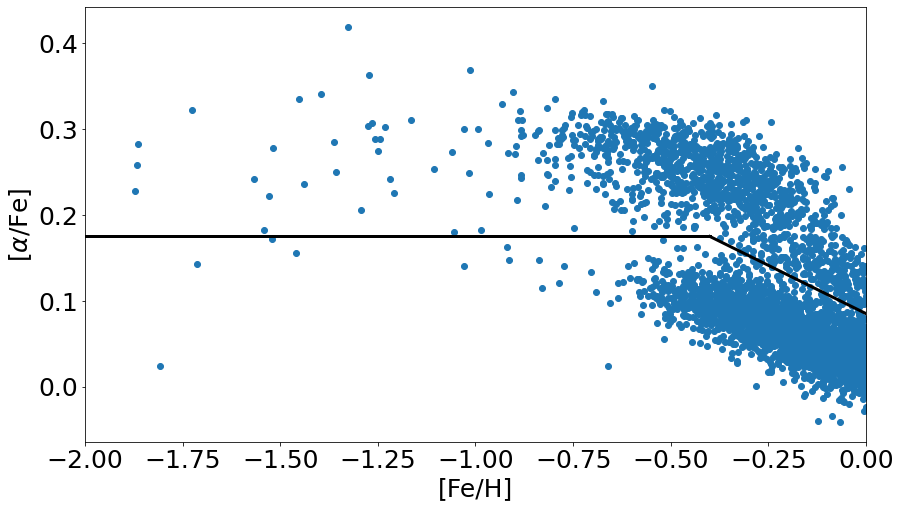

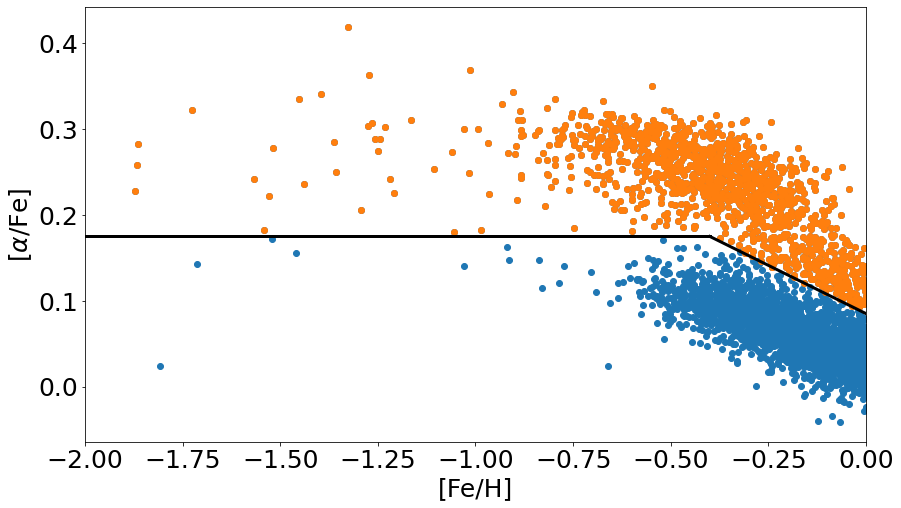

In [7]:
plt.figure(figsize=[14,8])
plt.scatter(kasc3dr17['FE_H'],(kasc3dr17['ALPHA_M']+kasc3dr17['M_H']-kasc3dr17['FE_H']))

plt.plot([-2.,-0.4],[0.175,0.175],c='k',lw=3.)
plt.plot([-0.4,0.0],[0.175,0.085],c='k',lw=3.)
plt.xlim(-2.0,0.0)

plt.xlabel(r'[Fe/H]')
plt.ylabel(r'[$\alpha$/Fe]')
plt.show()

def alphaboundary(feh):
    '''
    Boundary between high alpha and low alpha
    
    (x0,y0): (-0.4,0.175), (x1,y1): (0.0,0.085)
    
    Input:
    -----
        feh: [Fe/H]
    
    Output:
    ------
        ups: value on boundary
    '''
    ups = np.ones(np.size(feh))
    for i in range(np.size(feh)):
        if feh[i] <= -0.4:
            up = 0.175
        else:
            up = ((0.085-0.175)/(0.0--0.4))*(feh[i]--0.4)+0.175
            
        ups[i] = up
    return ups

higha = np.where((kasc3dr17['ALPHA_M']+kasc3dr17['M_H']-kasc3dr17['FE_H'])-alphaboundary(kasc3dr17['FE_H'])>0.0)
lowa = np.where((kasc3dr17['ALPHA_M']+kasc3dr17['M_H']-kasc3dr17['FE_H'])-alphaboundary(kasc3dr17['FE_H'])<0.0)

plt.figure(figsize=[14,8])
plt.scatter(kasc3dr17['FE_H'],(kasc3dr17['ALPHA_M']+kasc3dr17['M_H']-kasc3dr17['FE_H']))
plt.scatter(kasc3dr17['FE_H'][higha],(kasc3dr17['ALPHA_M']+kasc3dr17['M_H']-kasc3dr17['FE_H'])[higha])

plt.plot([-2.,-0.4],[0.175,0.175],c='k',lw=3.)
plt.plot([-0.4,0.0],[0.175,0.085],c='k',lw=3.)
plt.xlim(-2.0,0.0)

plt.xlabel(r'[Fe/H]')
plt.ylabel(r'[$\alpha$/Fe]')
plt.show()

# Gaia Error

In [8]:
from scipy.stats import binned_statistic
gaiaedr3 = fits.getdata('/Users/joshuapovick/Desktop/Research/gaia/GAIAEDR3allStar.fits.gz')

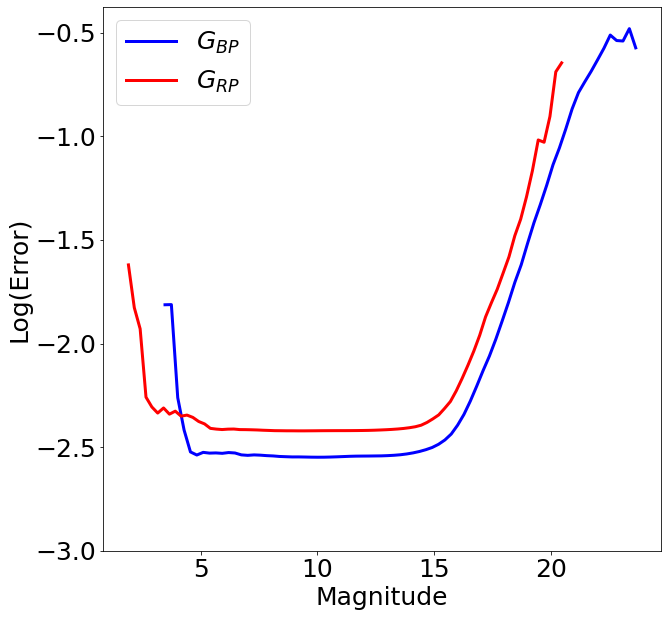

In [9]:
binnum = 75

### BP
bp_fin = np.where(np.isfinite(gaiaedr3['phot_bp_mean_mag'])==True)

bpmin = min(gaiaedr3['phot_bp_mean_mag'][bp_fin])
bpmax = max(gaiaedr3['phot_bp_mean_mag'][bp_fin])

bpdiff = bpmax-bpmin
bpfluxerr = (2.5*0.434)/gaiaedr3['phot_bp_mean_flux_over_error'][bp_fin]
bpmagerr = np.sqrt((bpfluxerr)**2+0.0027901700**2)

bpbin ,_,_ = binned_statistic(gaiaedr3['phot_bp_mean_mag'][bp_fin],np.log10(bpmagerr),'median',bins=binnum)

### RP 
rp_fin = np.where(np.isfinite(gaiaedr3['phot_rp_mean_mag'])==True)

rpmin = min(gaiaedr3['phot_rp_mean_mag'][rp_fin])
rpmax = max(gaiaedr3['phot_rp_mean_mag'][rp_fin])

rpdiff = rpmax-rpmin
rpfluxerr = (2.5*0.434)/gaiaedr3['phot_rp_mean_flux_over_error'][rp_fin]
rpmagerr = np.sqrt((rpfluxerr)**2+0.0037793818**2)

rpbin ,_,_ = binned_statistic(gaiaedr3['phot_rp_mean_mag'][rp_fin],np.log10(rpmagerr),'median',bins=binnum)

### Plot
plt.figure(figsize=[10,10])
plt.plot(np.arange(bpmin,bpmax,bpdiff/binnum),bpbin,lw=3.0,c='blue',label=r'$G_{BP}$')
plt.plot(np.arange(rpmin,rpmax,rpdiff/binnum),rpbin,lw=3.0,c='red',label=r'$G_{RP}$')
plt.legend()
plt.ylim(bottom=-3.0)
plt.xlabel('Magnitude')
plt.ylabel('Log(Error)');

bperrfunc = IUS(np.arange(bpmin,bpmax,bpdiff/binnum),bpbin)
rperrfunc = IUS(np.arange(rpmin,rpmax,rpdiff/binnum),rpbin)

bperr = 10**bperrfunc(kasc3dr17['GAIAEDR3_PHOT_BP_MEAN_MAG'])
rperr = 10**rperrfunc(kasc3dr17['GAIAEDR3_PHOT_RP_MEAN_MAG'])

# Ages

In [10]:
ages0 = fits.getdata('/Users/joshuapovick/Desktop/Research/LMC_Ages/Age_Fitting/notebooks/APOKASC_rgb_Sal_age_ak.fits')
ages125 = fits.getdata('/Users/joshuapovick/Desktop/Research/LMC_Ages/Age_Fitting/notebooks/APOKASC_rgb_TeffPos_HighALPHA125.fits')
ages25 = fits.getdata('/Users/joshuapovick/Desktop/Research/LMC_Ages/Age_Fitting/notebooks/APOKASC_rgb_TeffPos25_HighALPHA.fits')
ages375 = fits.getdata('/Users/joshuapovick/Desktop/Research/LMC_Ages/Age_Fitting/notebooks/APOKASC_rgb_TeffPos_HighALPHA375.fits')
ages50 = fits.getdata('/Users/joshuapovick/Desktop/Research/LMC_Ages/Age_Fitting/notebooks/APOKASC_rgb_TeffPos50_HighALPHA.fits')

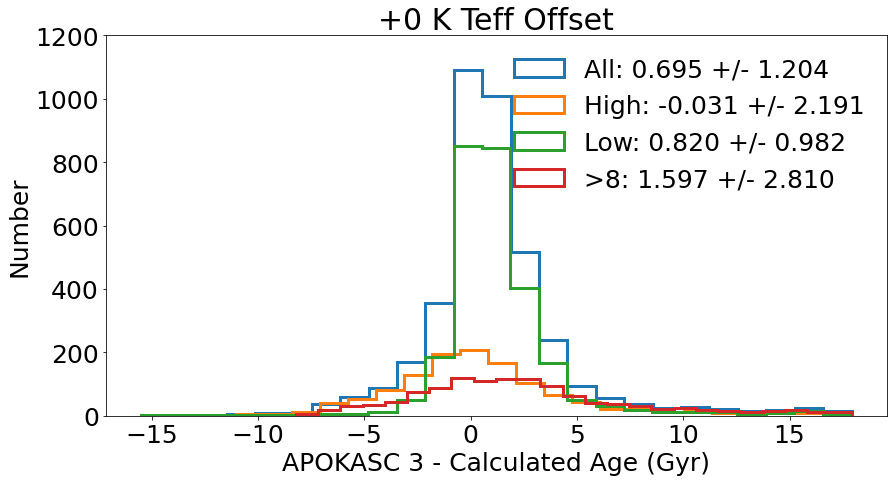

In [11]:
allbad0 = np.where((ages0['AGE']<100.)&(kasc3['IntAge']-ages0['AGE']<18.))
hibad0 = np.where((ages0['AGE'][higha]<100.)&((kasc3['IntAge']-ages0['AGE'])[higha]<18.))
lobad0 = np.where((ages0['AGE'][lowa]<100.)&((kasc3['IntAge']-ages0['AGE'])[lowa]<18.))
_8bad0 = np.where((ages0['AGE']<100.)&(kasc3['IntAge']>8.)&(kasc3['IntAge']-ages0['AGE']<18.))

plt.figure(figsize=[14,7])
plt.hist((kasc3['IntAge']-ages0['AGE'])[allbad0],bins=25,histtype='step',lw=3.0,
         label='All: {:.3f} +/- {:.3f}'.format(np.median((kasc3['IntAge']-ages0['AGE'])[allbad0]),mad((kasc3['IntAge']-ages0['AGE'])[allbad0])))
plt.hist((kasc3['IntAge']-ages0['AGE'])[higha][hibad0],bins=25,histtype='step',lw=3.0,
         label='High: {:.3f} +/- {:.3f}'.format(np.median((kasc3['IntAge']-ages0['AGE'])[higha][hibad0]),mad((kasc3['IntAge']-ages0['AGE'])[higha][hibad0])))
plt.hist((kasc3['IntAge']-ages0['AGE'])[lowa][lobad0],bins=25,histtype='step',lw=3.0,
         label='Low: {:.3f} +/- {:.3f}'.format(np.median((kasc3['IntAge']-ages0['AGE'])[lowa][lobad0]),mad((kasc3['IntAge']-ages0['AGE'])[lowa][lobad0])))

plt.hist((kasc3['IntAge']-ages0['AGE'])[_8bad0],bins=25,histtype='step',lw=3.0,
         label='>8: {:.3f} +/- {:.3f}'.format(np.median((kasc3['IntAge']-ages0['AGE'])[_8bad0]),mad((kasc3['IntAge']-ages0['AGE'])[_8bad0])))

plt.ylim(top=1200)

plt.legend(frameon=False)
plt.title('+0 K Teff Offset')
plt.xlabel(r'APOKASC 3 - Calculated Age (Gyr)')
plt.ylabel(r'Number')
plt.savefig('../plots/age_histogram0_1200.pdf',dpi=300,bbox_inches='tight')
plt.show()

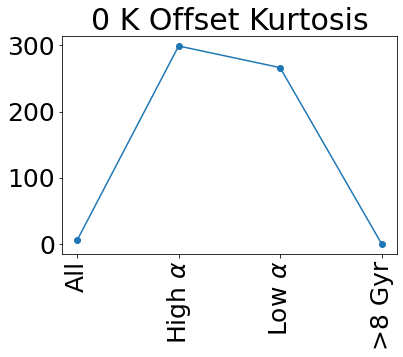

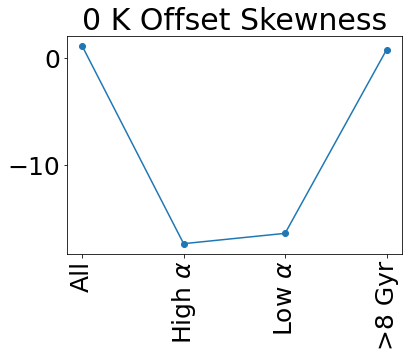

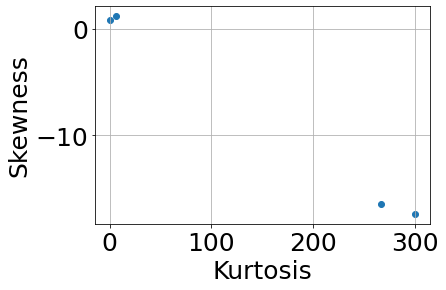

In [12]:
from scipy.stats import kurtosis, skew

### Kurtosis for 0K offset
kurtall0 = kurtosis((kasc3['IntAge']-ages0['AGE'])[allbad0])
kurthi0 = kurtosis((kasc3['IntAge']-ages0['AGE'])[hibad0])
kurtlo0 = kurtosis((kasc3['IntAge']-ages0['AGE'])[lobad0])
kurt80 = kurtosis((kasc3['IntAge']-ages0['AGE'])[_8bad0])

### Skewness for 0K offset
skewall0 = skew((kasc3['IntAge']-ages0['AGE'])[allbad0])
skewhi0 = skew((kasc3['IntAge']-ages0['AGE'])[hibad0])
skewlo0 = skew((kasc3['IntAge']-ages0['AGE'])[lobad0])
skew80 = skew((kasc3['IntAge']-ages0['AGE'])[_8bad0])

### Kurtosis Plot
plt.figure()
plt.plot([kurtall0,kurthi0,kurtlo0,kurt80],marker='o',)
plt.xticks(range(4),['All',r'High $\alpha$',r'Low $\alpha$','>8 Gyr'],rotation=90)
plt.title(r'0 K Offset Kurtosis')
plt.show()

### Skewness Plot
plt.figure()
plt.plot([skewall0,skewhi0,skewlo0,skew80],marker='o',)
plt.xticks(range(4),['All',r'High $\alpha$',r'Low $\alpha$','>8 Gyr'],rotation=90)
plt.title(r'0 K Offset Skewness')
plt.show()

### Kurtosis-Skewness Plot
plt.figure()
plt.scatter([kurtall0,kurthi0,kurtlo0,kurt80],[skewall0,skewhi0,skewlo0,skew80])
plt.grid()
plt.xlabel(r'Kurtosis')
plt.ylabel(r'Skewness')
plt.show()

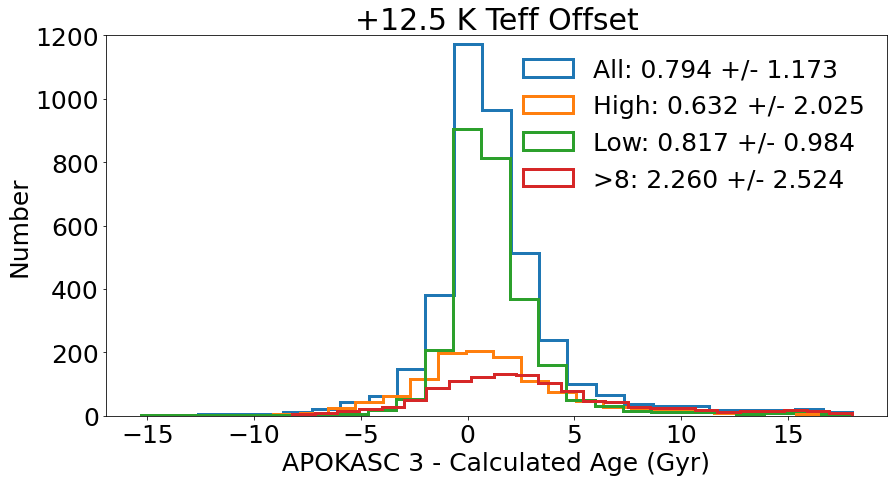

In [13]:
allbad125 = np.where((ages125['AGE']<100.)&(kasc3['IntAge']-ages125['AGE']<18.))
hibad125 = np.where((ages125['AGE'][higha]<100.)&((kasc3['IntAge']-ages125['AGE'])[higha]<18.))
lobad125 = np.where((ages125['AGE'][lowa]<100.)&((kasc3['IntAge']-ages125['AGE'])[lowa]<18.))
_8bad125 = np.where((ages125['AGE']<100.)&(kasc3['IntAge']>8.)&(kasc3['IntAge']-ages125['AGE']<18.))

plt.figure(figsize=[14,7])
plt.hist((kasc3['IntAge']-ages125['AGE'])[allbad125],bins=25,histtype='step',lw=3.0,
         label='All: {:.3f} +/- {:.3f}'.format(np.median((kasc3['IntAge']-ages125['AGE'])[allbad125]),mad((kasc3['IntAge']-ages125['AGE'])[allbad125])))
plt.hist((kasc3['IntAge']-ages125['AGE'])[higha][hibad125],bins=25,histtype='step',lw=3.0,
         label='High: {:.3f} +/- {:.3f}'.format(np.median((kasc3['IntAge']-ages125['AGE'])[higha][hibad125]),mad((kasc3['IntAge']-ages125['AGE'])[higha][hibad125])))
plt.hist((kasc3['IntAge']-ages125['AGE'])[lowa][lobad125],bins=25,histtype='step',lw=3.0,
         label='Low: {:.3f} +/- {:.3f}'.format(np.median((kasc3['IntAge']-ages125['AGE'])[lowa][lobad125]),mad((kasc3['IntAge']-ages125['AGE'])[lowa][lobad125])))

plt.hist((kasc3['IntAge']-ages125['AGE'])[_8bad125],bins=25,histtype='step',lw=3.0,
         label='>8: {:.3f} +/- {:.3f}'.format(np.median((kasc3['IntAge']-ages125['AGE'])[_8bad125]),mad((kasc3['IntAge']-ages125['AGE'])[_8bad125])))

plt.ylim(top=1200)

plt.legend(frameon=False)
plt.title('+12.5 K Teff Offset')
plt.xlabel(r'APOKASC 3 - Calculated Age (Gyr)')
plt.ylabel(r'Number')
plt.savefig('../plots/age_histogram125_1200.pdf',dpi=300,bbox_inches='tight')
plt.show()

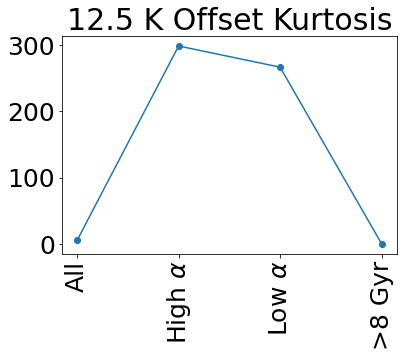

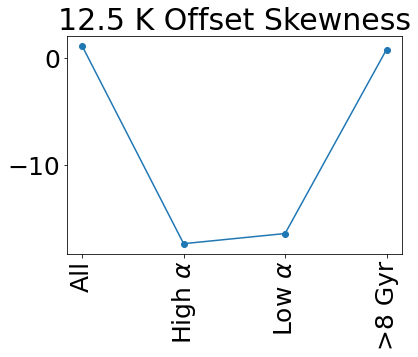

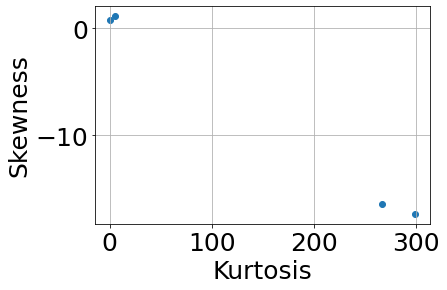

In [14]:
### Kurtosis for 12.5 K offset
kurtall125 = kurtosis((kasc3['IntAge']-ages0['AGE'])[allbad125])
kurthi125 = kurtosis((kasc3['IntAge']-ages0['AGE'])[hibad125])
kurtlo125 = kurtosis((kasc3['IntAge']-ages0['AGE'])[lobad125])
kurt8125 = kurtosis((kasc3['IntAge']-ages0['AGE'])[_8bad125])

### Skewness for 12.5 K offset
skewall125 = skew((kasc3['IntAge']-ages0['AGE'])[allbad125])
skewhi125 = skew((kasc3['IntAge']-ages0['AGE'])[hibad125])
skewlo125 = skew((kasc3['IntAge']-ages0['AGE'])[lobad125])
skew8125 = skew((kasc3['IntAge']-ages0['AGE'])[_8bad125])

### Kurtosis Plot
plt.figure()
plt.plot([kurtall125,kurthi125,kurtlo125,kurt8125],marker='o',)
plt.xticks(range(4),['All',r'High $\alpha$',r'Low $\alpha$','>8 Gyr'],rotation=90)
plt.title(r'12.5 K Offset Kurtosis')
plt.show()

### Skewness Plot
plt.figure()
plt.plot([skewall125,skewhi125,skewlo125,skew8125],marker='o',)
plt.xticks(range(4),['All',r'High $\alpha$',r'Low $\alpha$','>8 Gyr'],rotation=90)
plt.title(r'12.5 K Offset Skewness')
plt.show()

### Kurtosis-Skewness Plot
plt.figure()
plt.scatter([kurtall125,kurthi125,kurtlo125,kurt8125],[skewall125,skewhi125,skewlo125,skew8125])
plt.grid()
plt.xlabel(r'Kurtosis')
plt.ylabel(r'Skewness')
plt.show()

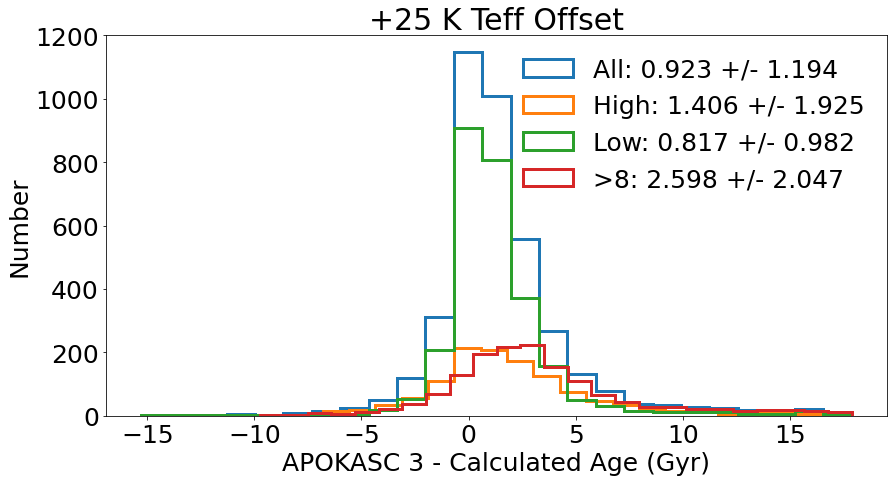

In [15]:
allbad25 = np.where((ages25['AGE']<100.)&(kasc3['IntAge']-ages25['AGE']<18.))
hibad25 = np.where((ages25['AGE'][higha]<100.)&((kasc3['IntAge']-ages25['AGE'])[higha]<18.))
lobad25 = np.where((ages25['AGE'][lowa]<100.)&((kasc3['IntAge']-ages25['AGE'])[lowa]<18.))
_8bad25 = np.where((ages25['AGE']<100.)&(kasc3['IntAge']>7.)&(kasc3['IntAge']-ages25['AGE']<18.))

plt.figure(figsize=[14,7])
plt.hist((kasc3['IntAge']-ages25['AGE'])[allbad25],bins=25,histtype='step',lw=3.0,
         label='All: {:.3f} +/- {:.3f}'.format(np.median((kasc3['IntAge']-ages25['AGE'])[allbad25]),mad((kasc3['IntAge']-ages25['AGE'])[allbad25])))
plt.hist((kasc3['IntAge']-ages25['AGE'])[higha][hibad25],bins=25,histtype='step',lw=3.0,
         label='High: {:.3f} +/- {:.3f}'.format(np.median((kasc3['IntAge']-ages25['AGE'])[higha][hibad25]),mad((kasc3['IntAge']-ages25['AGE'])[higha][hibad25])))
plt.hist((kasc3['IntAge']-ages25['AGE'])[lowa][lobad25],bins=25,histtype='step',lw=3.0,
         label='Low: {:.3f} +/- {:.3f}'.format(np.median((kasc3['IntAge']-ages25['AGE'])[lowa][lobad25]),mad((kasc3['IntAge']-ages25['AGE'])[lowa][lobad25])))

plt.hist((kasc3['IntAge']-ages25['AGE'])[_8bad25],bins=25,histtype='step',lw=3.0,
         label='>8: {:.3f} +/- {:.3f}'.format(np.median((kasc3['IntAge']-ages25['AGE'])[_8bad25]),mad((kasc3['IntAge']-ages25['AGE'])[_8bad25])))

plt.ylim(top=1200)

plt.legend(frameon=False)
plt.title('+25 K Teff Offset')
plt.xlabel(r'APOKASC 3 - Calculated Age (Gyr)')
plt.ylabel(r'Number')
plt.savefig('../plots/age_histogram25_1200.pdf',dpi=300,bbox_inches='tight')
plt.show()

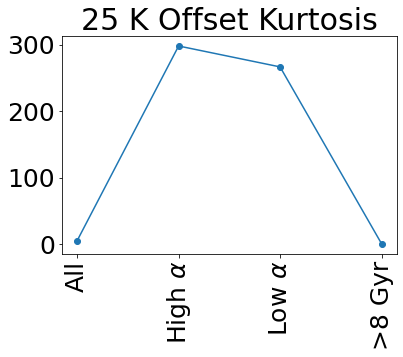

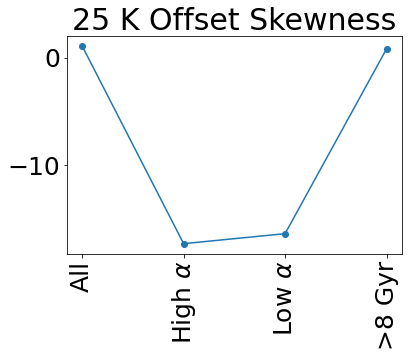

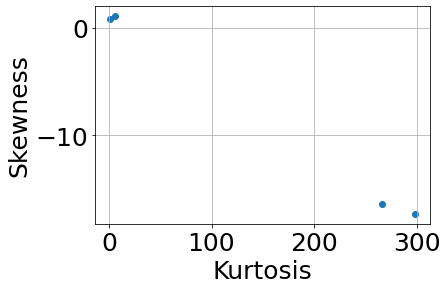

In [16]:
### Kurtosis for 25 K offset
kurtall25 = kurtosis((kasc3['IntAge']-ages0['AGE'])[allbad25])
kurthi25 = kurtosis((kasc3['IntAge']-ages0['AGE'])[hibad25])
kurtlo25 = kurtosis((kasc3['IntAge']-ages0['AGE'])[lobad25])
kurt825 = kurtosis((kasc3['IntAge']-ages0['AGE'])[_8bad25])

### Skewness for 25 K offset
skewall25 = skew((kasc3['IntAge']-ages0['AGE'])[allbad25])
skewhi25 = skew((kasc3['IntAge']-ages0['AGE'])[hibad25])
skewlo25 = skew((kasc3['IntAge']-ages0['AGE'])[lobad25])
skew825 = skew((kasc3['IntAge']-ages0['AGE'])[_8bad25])

### Kurtosis Plot
plt.figure()
plt.plot([kurtall25,kurthi25,kurtlo25,kurt825],marker='o',)
plt.xticks(range(4),['All',r'High $\alpha$',r'Low $\alpha$','>8 Gyr'],rotation=90)
plt.title(r'25 K Offset Kurtosis')
plt.show()

### Skewness Plot
plt.figure()
plt.plot([skewall25,skewhi25,skewlo25,skew825],marker='o',)
plt.xticks(range(4),['All',r'High $\alpha$',r'Low $\alpha$','>8 Gyr'],rotation=90)
plt.title(r'25 K Offset Skewness')
plt.show()

### Kurtosis-Skewness Plot
plt.figure()
plt.scatter([kurtall25,kurthi25,kurtlo25,kurt825],[skewall25,skewhi25,skewlo25,skew825])
plt.grid()
plt.xlabel(r'Kurtosis')
plt.ylabel(r'Skewness')
plt.show()

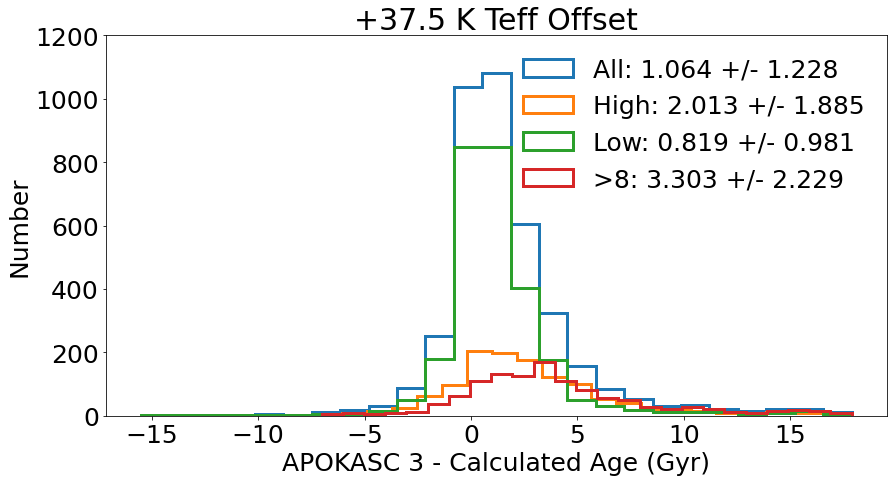

In [17]:
allbad375 = np.where((ages375['AGE']<100.)&(kasc3['IntAge']-ages375['AGE']<18.))
hibad375 = np.where((ages375['AGE'][higha]<100.)&((kasc3['IntAge']-ages375['AGE'])[higha]<18.))
lobad375 = np.where((ages375['AGE'][lowa]<100.)&((kasc3['IntAge']-ages375['AGE'])[lowa]<18.))
_8bad375 = np.where((ages375['AGE']<100.)&(kasc3['IntAge']>8.)&(kasc3['IntAge']-ages375['AGE']<18.))

plt.figure(figsize=[14,7])
plt.hist((kasc3['IntAge']-ages375['AGE'])[allbad375],bins=25,histtype='step',lw=3.0,
         label='All: {:.3f} +/- {:.3f}'.format(np.median((kasc3['IntAge']-ages375['AGE'])[allbad375]),mad((kasc3['IntAge']-ages375['AGE'])[allbad375])))
plt.hist((kasc3['IntAge']-ages375['AGE'])[higha][hibad375],bins=25,histtype='step',lw=3.0,
         label='High: {:.3f} +/- {:.3f}'.format(np.median((kasc3['IntAge']-ages375['AGE'])[higha][hibad375]),mad((kasc3['IntAge']-ages375['AGE'])[higha][hibad375])))
plt.hist((kasc3['IntAge']-ages375['AGE'])[lowa][lobad375],bins=25,histtype='step',lw=3.0,
         label='Low: {:.3f} +/- {:.3f}'.format(np.median((kasc3['IntAge']-ages375['AGE'])[lowa][lobad375]),mad((kasc3['IntAge']-ages375['AGE'])[lowa][lobad375])))

plt.hist((kasc3['IntAge']-ages375['AGE'])[_8bad375],bins=25,histtype='step',lw=3.0,
         label='>8: {:.3f} +/- {:.3f}'.format(np.median((kasc3['IntAge']-ages375['AGE'])[_8bad375]),mad((kasc3['IntAge']-ages375['AGE'])[_8bad375])))

plt.ylim(top=1200)

plt.legend(frameon=False)
plt.title('+37.5 K Teff Offset')
plt.xlabel(r'APOKASC 3 - Calculated Age (Gyr)')
plt.ylabel(r'Number')
plt.savefig('../plots/age_histogram375_1200.pdf',dpi=300,bbox_inches='tight')
plt.show()

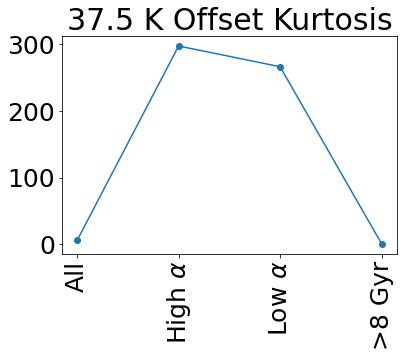

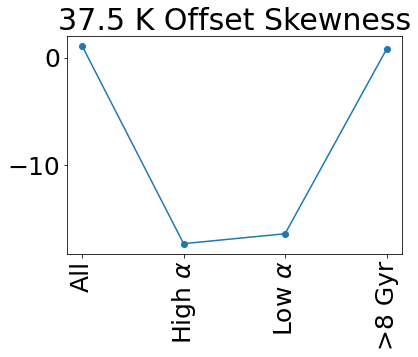

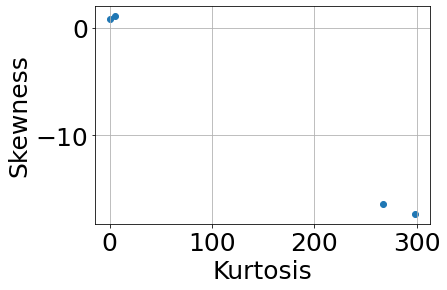

In [18]:
### Kurtosis for 37.5 K offset
kurtall375 = kurtosis((kasc3['IntAge']-ages0['AGE'])[allbad375])
kurthi375 = kurtosis((kasc3['IntAge']-ages0['AGE'])[hibad375])
kurtlo375 = kurtosis((kasc3['IntAge']-ages0['AGE'])[lobad375])
kurt8375 = kurtosis((kasc3['IntAge']-ages0['AGE'])[_8bad375])

### Skewness for 37.5 K offset
skewall375 = skew((kasc3['IntAge']-ages0['AGE'])[allbad375])
skewhi375 = skew((kasc3['IntAge']-ages0['AGE'])[hibad375])
skewlo375 = skew((kasc3['IntAge']-ages0['AGE'])[lobad375])
skew8375 = skew((kasc3['IntAge']-ages0['AGE'])[_8bad375])

### Kurtosis Plot
plt.figure()
plt.plot([kurtall375,kurthi375,kurtlo375,kurt8375],marker='o',)
plt.xticks(range(4),['All',r'High $\alpha$',r'Low $\alpha$','>8 Gyr'],rotation=90)
plt.title(r'37.5 K Offset Kurtosis')
plt.show()

### Skewness Plot
plt.figure()
plt.plot([skewall375,skewhi375,skewlo375,skew8375],marker='o',)
plt.xticks(range(4),['All',r'High $\alpha$',r'Low $\alpha$','>8 Gyr'],rotation=90)
plt.title(r'37.5 K Offset Skewness')
plt.show()

### Kurtosis-Skewness Plot
plt.figure()
plt.scatter([kurtall375,kurthi375,kurtlo375,kurt8375],[skewall375,skewhi375,skewlo375,skew8375])
plt.grid()
plt.xlabel(r'Kurtosis')
plt.ylabel(r'Skewness')
plt.show()

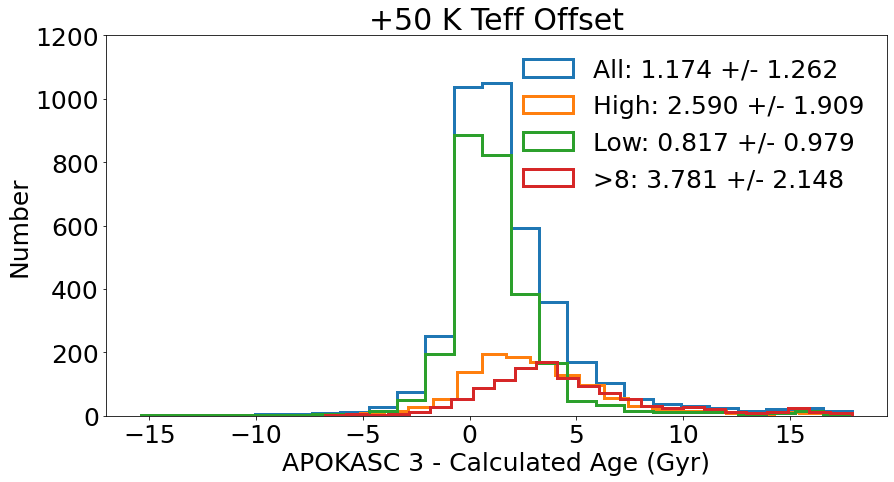

In [19]:
allbad50 = np.where((ages50['AGE']<100.)&(kasc3['IntAge']-ages50['AGE']<18.))
hibad50 = np.where((ages50['AGE'][higha]<100.)&((kasc3['IntAge']-ages50['AGE'])[higha]<18.))
lobad50 = np.where((ages50['AGE'][lowa]<100.)&((kasc3['IntAge']-ages50['AGE'])[lowa]<18.))
_8bad50 = np.where((ages50['AGE']<100.)&(kasc3['IntAge']>8.)&(kasc3['IntAge']-ages50['AGE']<18.))

plt.figure(figsize=[14,7])
plt.hist((kasc3['IntAge']-ages50['AGE'])[allbad50],bins=25,histtype='step',lw=3.0,
         label='All: {:.3f} +/- {:.3f}'.format(np.median((kasc3['IntAge']-ages50['AGE'])[allbad50]),mad((kasc3['IntAge']-ages50['AGE'])[allbad50])))
plt.hist((kasc3['IntAge']-ages50['AGE'])[higha][hibad50],bins=25,histtype='step',lw=3.0,
         label='High: {:.3f} +/- {:.3f}'.format(np.median((kasc3['IntAge']-ages50['AGE'])[higha][hibad50]),mad((kasc3['IntAge']-ages50['AGE'])[higha][hibad50])))
plt.hist((kasc3['IntAge']-ages50['AGE'])[lowa][lobad50],bins=25,histtype='step',lw=3.0,
         label='Low: {:.3f} +/- {:.3f}'.format(np.median((kasc3['IntAge']-ages50['AGE'])[lowa][lobad50]),mad((kasc3['IntAge']-ages50['AGE'])[lowa][lobad50])))

plt.hist((kasc3['IntAge']-ages50['AGE'])[_8bad50],bins=25,histtype='step',lw=3.0,
         label='>8: {:.3f} +/- {:.3f}'.format(np.median((kasc3['IntAge']-ages50['AGE'])[_8bad50]),mad((kasc3['IntAge']-ages50['AGE'])[_8bad50])))

plt.ylim(top=1200)

plt.legend(frameon=False)
plt.title('+50 K Teff Offset')
plt.xlabel(r'APOKASC 3 - Calculated Age (Gyr)')
plt.ylabel(r'Number')
plt.savefig('../plots/age_histogram50_1200.pdf',dpi=300,bbox_inches='tight')
plt.show()

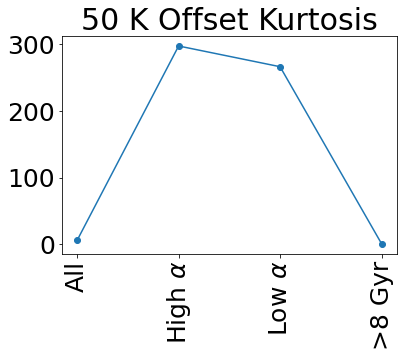

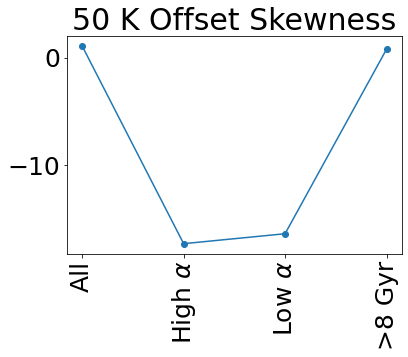

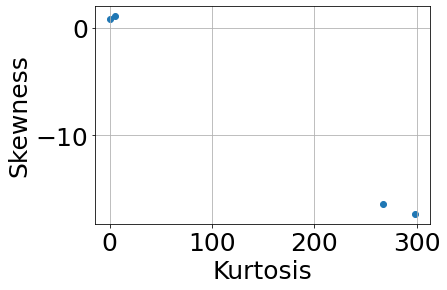

In [20]:
### Kurtosis for 50 K offset
kurtall50 = kurtosis((kasc3['IntAge']-ages0['AGE'])[allbad50])
kurthi50 = kurtosis((kasc3['IntAge']-ages0['AGE'])[hibad50])
kurtlo50 = kurtosis((kasc3['IntAge']-ages0['AGE'])[lobad50])
kurt850 = kurtosis((kasc3['IntAge']-ages0['AGE'])[_8bad50])

### Skewness for 50 K offset
skewall50 = skew((kasc3['IntAge']-ages0['AGE'])[allbad50])
skewhi50 = skew((kasc3['IntAge']-ages0['AGE'])[hibad50])
skewlo50 = skew((kasc3['IntAge']-ages0['AGE'])[lobad50])
skew850 = skew((kasc3['IntAge']-ages0['AGE'])[_8bad50])

### Kurtosis Plot
plt.figure()
plt.plot([kurtall50,kurthi50,kurtlo50,kurt850],marker='o',)
plt.xticks(range(4),['All',r'High $\alpha$',r'Low $\alpha$','>8 Gyr'],rotation=90)
plt.title(r'50 K Offset Kurtosis')
plt.show()

### Skewness Plot
plt.figure()
plt.plot([skewall50,skewhi50,skewlo50,skew850],marker='o',)
plt.xticks(range(4),['All',r'High $\alpha$',r'Low $\alpha$','>8 Gyr'],rotation=90)
plt.title(r'50 K Offset Skewness')
plt.show()

### Kurtosis-Skewness Plot
plt.figure()
plt.scatter([kurtall50,kurthi50,kurtlo50,kurt850],[skewall50,skewhi50,skewlo50,skew850])
plt.grid()
plt.xlabel(r'Kurtosis')
plt.ylabel(r'Skewness')
plt.show()

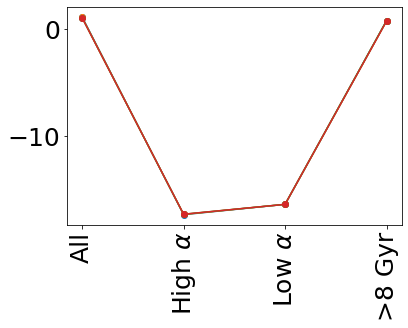

In [21]:
plt.figure()
plt.plot([skewall0,skewhi0,skewlo0,skew80],marker='o')
plt.plot([skewall125,skewhi125,skewlo125,skew8125],marker='o')
plt.plot([skewall25,skewhi25,skewlo25,skew825],marker='o')
plt.plot([skewall50,skewhi50,skewlo50,skew850],marker='o')
plt.xticks(range(4),['All',r'High $\alpha$',r'Low $\alpha$','>8 Gyr'],rotation=90)
plt.show()

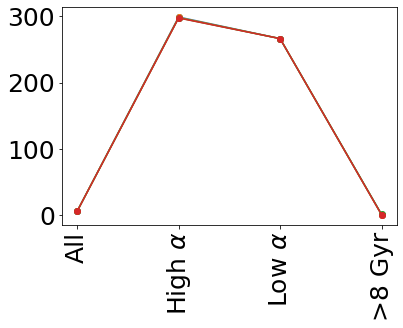

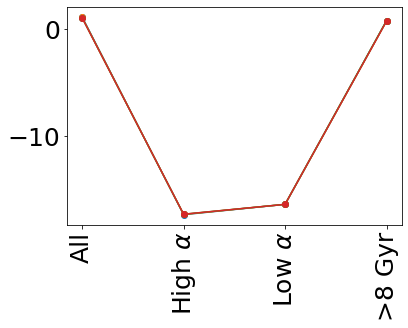

In [22]:
### Kurtosis Plot
plt.figure()
plt.plot([kurtall0,kurthi0,kurtlo0,kurt80],marker='o')
plt.plot([kurtall125,kurthi125,kurtlo125,kurt8125],marker='o')
plt.plot([kurtall25,kurthi25,kurtlo25,kurt825],marker='o')
plt.plot([kurtall50,kurthi50,kurtlo50,kurt850],marker='o')
plt.xticks(range(4),['All',r'High $\alpha$',r'Low $\alpha$','>8 Gyr'],rotation=90)
plt.show()

# ### Skewness Plot
plt.figure()
plt.plot([skewall0,skewhi0,skewlo0,skew80],marker='o')
plt.plot([skewall125,skewhi125,skewlo125,skew8125],marker='o')
plt.plot([skewall25,skewhi25,skewlo25,skew825],marker='o')
plt.plot([skewall50,skewhi50,skewlo50,skew850],marker='o')
plt.xticks(range(4),['All',r'High $\alpha$',r'Low $\alpha$','>8 Gyr'],rotation=90)
plt.show()

# ### Kurtosis-Skewness Plot
# plt.figure()
# plt.scatter([kurtall125,kurthi125,kurtlo125,kurt8125],[skewall125,skewhi125,skewlo125,skew8125])
# plt.grid()
# plt.xlabel(r'Kurtosis')
# plt.ylabel(r'Skewness')
# plt.show()

In [23]:
print('Kurtosis 0 K:',np.round([kurtall0,kurthi0,kurtlo0,kurt80],4))
print('Kurtosis 12.5 K:',np.round([kurtall125,kurthi125,kurtlo125,kurt8125],4))
print('Kurtosis 25 K:',np.round([kurtall25,kurthi25,kurtlo25,kurt825],4))
print('Kurtosis 37.5 K:',np.round([kurtall375,kurthi375,kurtlo375,kurt8375],4))
print('Kurtosis 50 K:',np.round([kurtall50,kurthi50,kurtlo50,kurt850],4))
print('------')
print('All Kurtosis Diffs:',np.diff([kurtall0,kurtall125,kurtall25,kurtall375,kurtall50]))
print('High Alpha Kurtosis Diffs:',np.diff([kurthi0,kurthi125,kurthi25,kurthi375,kurthi50]))
print('Low Alpha Kurtosis Diffs:',np.diff([kurtlo0,kurtlo125,kurtlo25,kurtlo375,kurtlo50]))
print('>8 Gyr Kurtosis Diffs:',np.diff([kurt80,kurt8125,kurt825,kurt8375,kurt850]))
print('------')
print('Skewness 0 K:',np.round([skewall0,skewhi0,skewlo0,skew80],4))
print('Skewness 12.5 K:',np.round([skewall125,skewhi125,skewlo125,skew8125],4))
print('Skewness 25 K:',np.round([skewall25,skewhi25,skewlo25,skew825],4))
print('Skewness 37.5 K:',np.round([skewall375,skewhi375,skewlo375,skew8375],4))
print('Skewness 50 K:',np.round([skewall50,skewhi50,skewlo50,skew850],4))
print('------')
print('All Skewness Diffs:',np.diff([skewall0,skewall125,skewall25,skewall375,skewall50]))
print('High Alpha Skewness Diffs:',np.diff([skewhi0,skewhi125,skewhi25,skewhi375,skewhi50]))
print('Low Alpha Skewness Diffs:',np.diff([skewlo0,skewlo125,skewlo25,skewlo375,skewlo50]))
print('>8 Gyr Skewness Diffs:',np.diff([skew80,skew8125,skew825,skew8375,skew850]))

Kurtosis 0 K: [  5.8107 299.2533 266.6037   0.5563]
Kurtosis 12.5 K: [  5.7032 298.5033 266.6037   0.5265]
Kurtosis 25 K: [  5.6721 298.0033 266.6037   1.1335]
Kurtosis 37.5 K: [  5.6491 297.7533 266.6037   0.521 ]
Kurtosis 50 K: [  5.6491 297.7533 266.6037   0.521 ]
------
All Kurtosis Diffs: [-0.10749063 -0.03111942 -0.02300613  0.        ]
High Alpha Kurtosis Diffs: [-0.74999181 -0.4999945  -0.24999725  0.        ]
Low Alpha Kurtosis Diffs: [0. 0. 0. 0.]
>8 Gyr Kurtosis Diffs: [-0.02976162  0.60698374 -0.61250721  0.        ]
------
Skewness 0 K: [  1.1701 -17.3566 -16.3891   0.8148]
Skewness 12.5 K: [  1.1228 -17.335  -16.3891   0.7951]
Skewness 25 K: [  1.0992 -17.3206 -16.3891   0.8253]
Skewness 37.5 K: [  1.0856 -17.3134 -16.3891   0.7826]
Skewness 50 K: [  1.0856 -17.3134 -16.3891   0.7826]
------
All Skewness Diffs: [-0.0473009  -0.02354114 -0.01361423  0.        ]
High Alpha Skewness Diffs: [0.02161878 0.01442751 0.00721826 0.        ]
Low Alpha Skewness Diffs: [0. 0. 0. 0.]


In [24]:
# allbad50 = np.where((ages50['AGE']<100.)&(kasc3['IntAge']-ages50['AGE']<18.))
# hibad50 = np.where((ages50['AGE'][higha]<100.)&((kasc3['IntAge']-ages50['AGE'])[higha]<18.))
# lobad50 = np.where((ages50['AGE'][lowa]<100.)&((kasc3['IntAge']-ages50['AGE'])[lowa]<18.))
# _8bad50 = np.where((ages50['AGE']<100.)&(kasc3['IntAge']>8.)&(kasc3['IntAge']-ages50['AGE']<18.))

# plt.figure(figsize=[14,7])
# plt.hist((kasc3['IntAge']-ages50['AGE'])[allbad50],bins=50,histtype='step',lw=3.0,
#          label='All: {:.3f} +/- {:.3f}'.format(np.median((kasc3['IntAge']-ages50['AGE'])[allbad50]),mad((kasc3['IntAge']-ages50['AGE'])[allbad50])))
# plt.hist((kasc3['IntAge']-ages50['AGE'])[higha][hibad50],bins=50,histtype='step',lw=3.0,
#          label='High: {:.3f} +/- {:.3f}'.format(np.median((kasc3['IntAge']-ages50['AGE'])[higha][hibad50]),mad((kasc3['IntAge']-ages50['AGE'])[higha][hibad50])))
# plt.hist((kasc3['IntAge']-ages50['AGE'])[lowa][lobad50],bins=50,histtype='step',lw=3.0,
#          label='Low: {:.3f} +/- {:.3f}'.format(np.median((kasc3['IntAge']-ages50['AGE'])[lowa][lobad50]),mad((kasc3['IntAge']-ages50['AGE'])[lowa][lobad50])))

# plt.hist((kasc3['IntAge']-ages50['AGE'])[_8bad50],bins=25,histtype='step',lw=3.0,
#          label='>8: {:.3f} +/- {:.3f}'.format(np.median((kasc3['IntAge']-ages50['AGE'])[_8bad50]),mad((kasc3['IntAge']-ages50['AGE'])[_8bad50])))

# plt.ylim(top=1200)

# plt.legend(frameon=False)
# plt.title('+50 K Teff Offset')
# plt.xlabel(r'APOKASC 3 - Calculated Age (Gyr)')
# plt.ylabel(r'Number')
# plt.savefig('../plots/age_histogram50_1200.pdf',dpi=300,bbox_inches='tight')
plt.show()

# Age-Age

In [25]:
def upturn10Gyr(age):
    '''
    Boundary for 10 Gyr upturn in Aetas and APOKASC plot 
    
    Input:
    -----
        age: age in Gyr
        
    Output:
    ------
        ups: value on boundary 
    '''
    ups = np.ones(np.size(age))
    for i in range(np.size(age)):
        if age[i] <= 11:
            up = 11

        else:
            up = age[i]
            
        ups[i] = up

    return ups

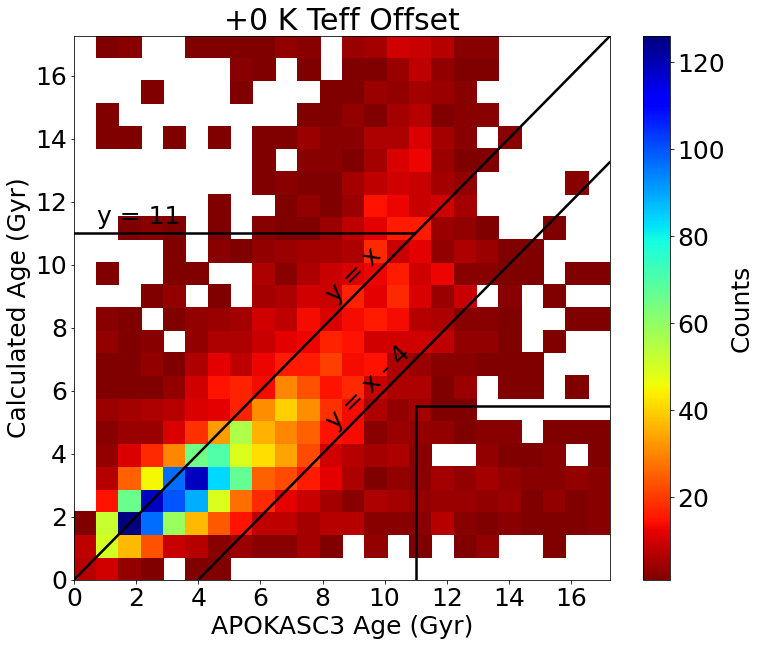

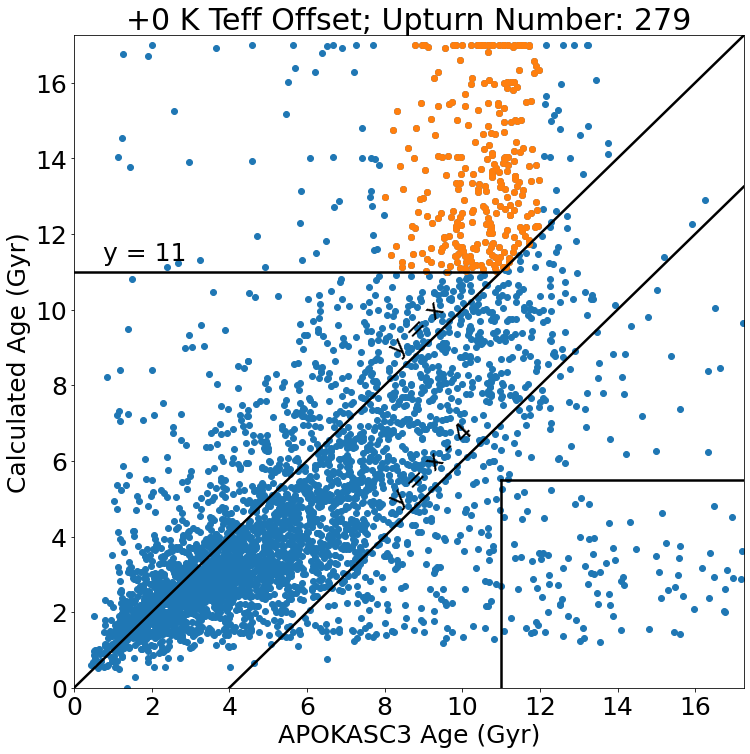

In [26]:
##########
### +0 ###
##########

xmax = 18
ymax = 18
nbins = 25

plt.figure(figsize=[12,10])
plt.hist2d(kasc3['IntAge'][allbad0],ages0['AGE'][allbad0],
           bins=[np.arange(0,xmax,xmax/nbins),np.arange(0,ymax,ymax/25)],cmap='jet_r',cmin=1)
plt.text(8,8.8,'y = x',rotation=45)
plt.text(8,4.8,'y = x - 4',rotation=45)
plt.text(0.75,11.3,'y = 11')

plt.plot([0,18],[0,18],lw=2.5,c='k')
plt.plot([4,17.25],[0,13.25],lw=2.5,c='k')
plt.plot([0,10.95],[11,11],lw=2.5,c='k')

plt.plot([11,11],[0,5.5],c='k',lw=2.5)
plt.plot([11,18],[5.5,5.5],c='k',lw=2.5)

plt.xlim(0,17.25)
plt.ylim(0,17.25)

plt.xticks(np.arange(0,17)[::2],np.arange(0,17)[::2].astype('str'))

plt.xlabel('APOKASC3 Age (Gyr)')
plt.ylabel('Calculated Age (Gyr)')
cbar = plt.colorbar()
cbar.ax.set_ylabel('Counts')
plt.title(r'+0 K Teff Offset')

### Scatter

upbox0 = np.where((ages0['AGE'][allbad0]-upturn10Gyr(kasc3['IntAge'][allbad0])>0.0)&
         (kasc3['IntAge'][allbad0]>8.0)&(kasc3['IntAge'][allbad0]<12))

plt.figure(figsize=[12,12])
plt.scatter(kasc3['IntAge'][allbad0],ages0['AGE'][allbad0])
plt.scatter(kasc3['IntAge'][allbad0][upbox0],ages0['AGE'][allbad0][upbox0])
plt.text(8,8.8,'y = x',rotation=45)
plt.text(8,4.8,'y = x - 4',rotation=45)
plt.text(0.75,11.3,'y = 11')

plt.plot([0,18],[0,18],lw=2.5,c='k')
plt.plot([4,17.25],[0,13.25],lw=2.5,c='k')
plt.plot([0,10.95],[11,11],lw=2.5,c='k')

plt.plot([11,11],[0,5.5],c='k',lw=2.5)
plt.plot([11,18],[5.5,5.5],c='k',lw=2.5)

plt.xlim(0,17.25)
plt.ylim(0,17.25)

plt.xticks(np.arange(0,17)[::2],np.arange(0,17)[::2].astype('str'))

plt.xlabel('APOKASC3 Age (Gyr)')
plt.ylabel('Calculated Age (Gyr)')
# cbar = plt.colorbar()
# cbar.ax.set_ylabel('Counts')
plt.title(r'+0 K Teff Offset; Upturn Number: {}'.format(len(np.squeeze(upbox0))))
plt.savefig('../plots/age_age_scatter0.pdf',dpi=300,bbox_inches='tight')
plt.show()

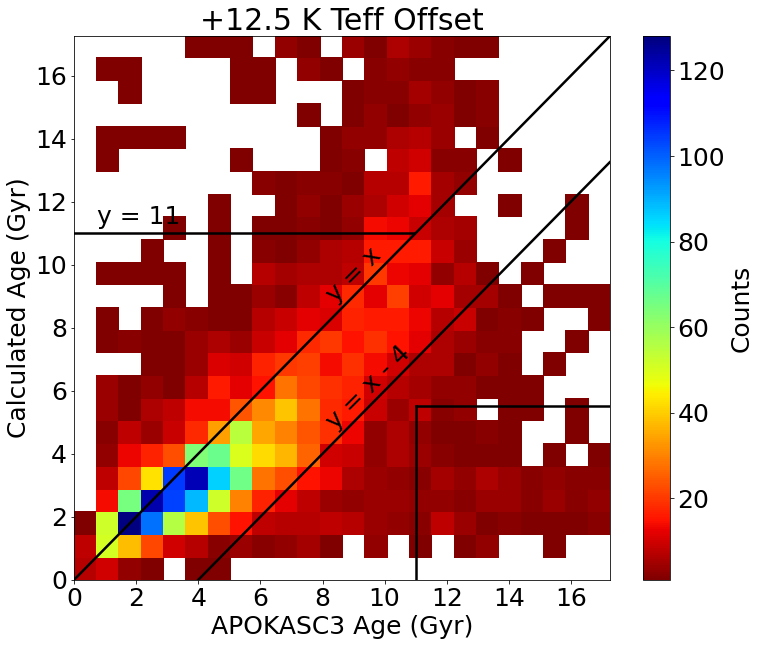

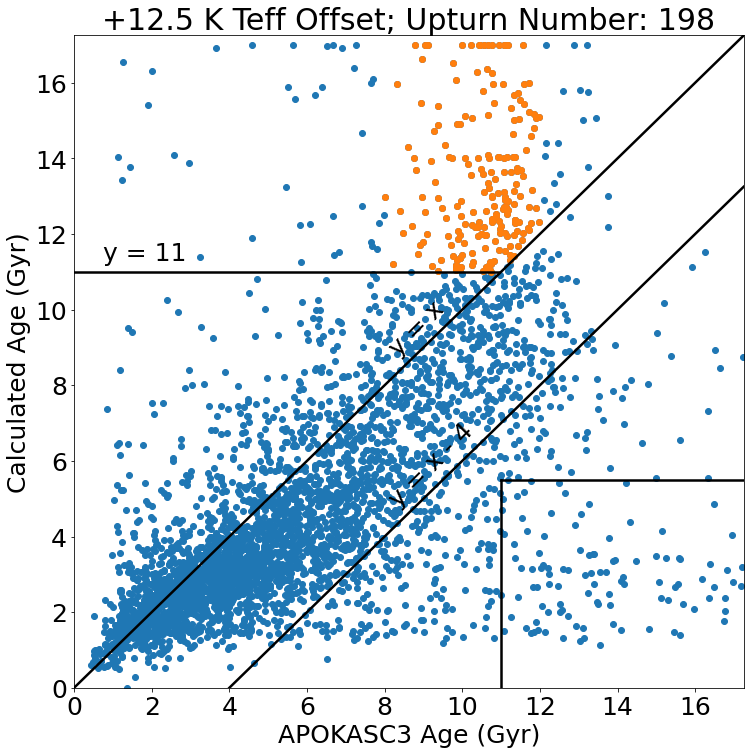

In [27]:
#############
### +12.5 ###
#############

xmax = 18
ymax = 18
nbins = 25

plt.figure(figsize=[12,10])
plt.hist2d(kasc3['IntAge'][allbad125],ages125['AGE'][allbad125],
           bins=[np.arange(0,xmax,xmax/nbins),np.arange(0,ymax,ymax/25)],cmap='jet_r',cmin=1)
plt.text(8,8.8,'y = x',rotation=45)
plt.text(8,4.8,'y = x - 4',rotation=45)
plt.text(0.75,11.3,'y = 11')

plt.plot([0,18],[0,18],lw=2.5,c='k')
plt.plot([4,17.25],[0,13.25],lw=2.5,c='k')
plt.plot([0,10.95],[11,11],lw=2.5,c='k')

plt.plot([11,11],[0,5.5],c='k',lw=2.5)
plt.plot([11,18],[5.5,5.5],c='k',lw=2.5)

plt.xlim(0,17.25)
plt.ylim(0,17.25)

plt.xticks(np.arange(0,17)[::2],np.arange(0,17)[::2].astype('str'))

plt.xlabel('APOKASC3 Age (Gyr)')
plt.ylabel('Calculated Age (Gyr)')
cbar = plt.colorbar()
cbar.ax.set_ylabel('Counts')
plt.title(r'+12.5 K Teff Offset')

### Scatter

upbox125 = np.where((ages125['AGE'][allbad125]-upturn10Gyr(kasc3['IntAge'][allbad125])>0.0)&
         (kasc3['IntAge'][allbad125]>8.0)&(kasc3['IntAge'][allbad125]<12))

plt.figure(figsize=[12,12])
plt.scatter(kasc3['IntAge'][allbad125],ages125['AGE'][allbad125])
plt.scatter(kasc3['IntAge'][allbad125][upbox125],ages125['AGE'][allbad125][upbox125])
plt.text(8,8.8,'y = x',rotation=45)
plt.text(8,4.8,'y = x - 4',rotation=45)
plt.text(0.75,11.3,'y = 11')

plt.plot([0,18],[0,18],lw=2.5,c='k')
plt.plot([4,17.25],[0,13.25],lw=2.5,c='k')
plt.plot([0,10.95],[11,11],lw=2.5,c='k')

plt.plot([11,11],[0,5.5],c='k',lw=2.5)
plt.plot([11,18],[5.5,5.5],c='k',lw=2.5)

plt.xlim(0,17.25)
plt.ylim(0,17.25)

plt.xticks(np.arange(0,17)[::2],np.arange(0,17)[::2].astype('str'))

plt.xlabel('APOKASC3 Age (Gyr)')
plt.ylabel('Calculated Age (Gyr)')
# cbar = plt.colorbar()
# cbar.ax.set_ylabel('Counts')
plt.title(r'+12.5 K Teff Offset; Upturn Number: {}'.format(len(np.squeeze(upbox125))))
plt.savefig('../plots/age_age_scatter125.pdf',dpi=300,bbox_inches='tight')
plt.show()

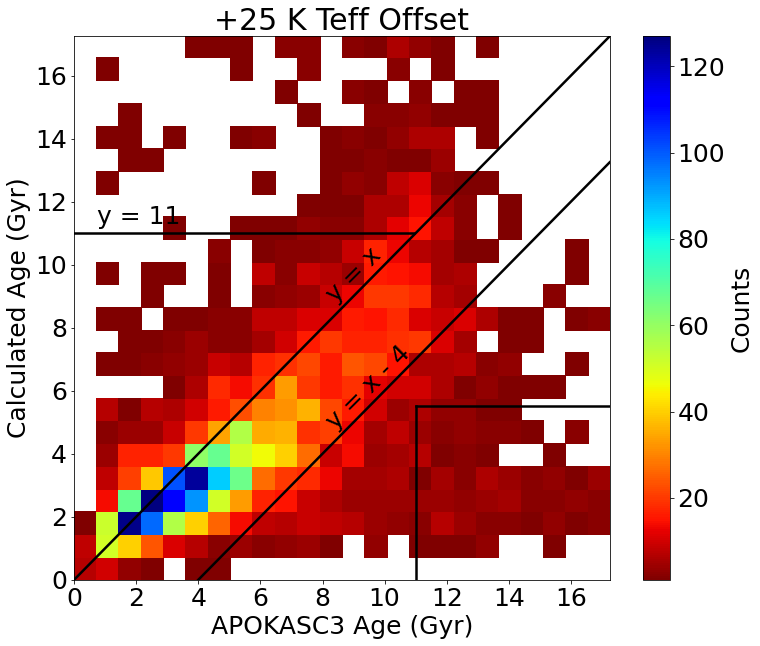

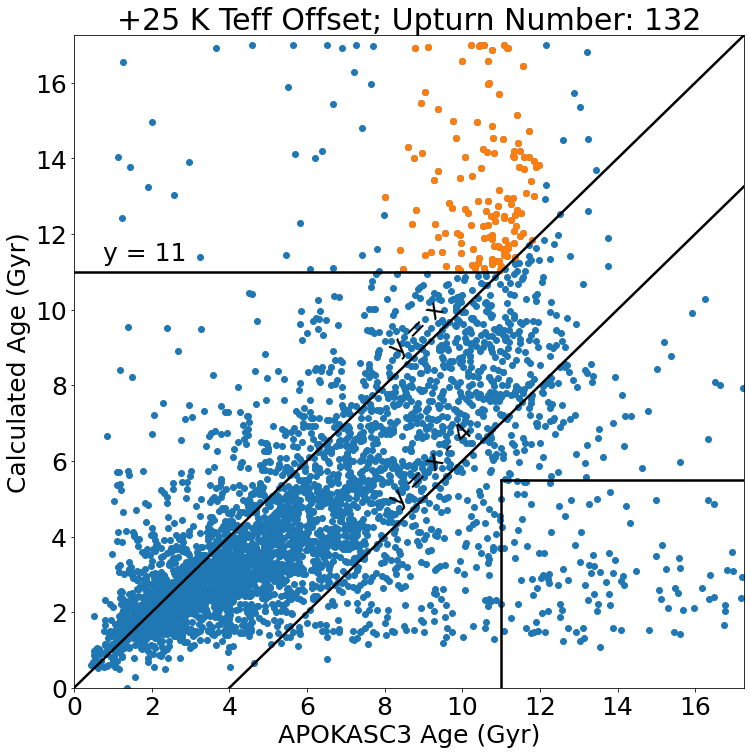

In [28]:
###########
### +25 ###
###########

xmax = 18
ymax = 18
nbins = 25

plt.figure(figsize=[12,10])
plt.hist2d(kasc3['IntAge'][allbad25],ages25['AGE'][allbad25],
           bins=[np.arange(0,xmax,xmax/nbins),np.arange(0,ymax,ymax/25)],cmap='jet_r',cmin=1)
plt.text(8,8.8,'y = x',rotation=45)
plt.text(8,4.8,'y = x - 4',rotation=45)
plt.text(0.75,11.3,'y = 11')

plt.plot([0,18],[0,18],lw=2.5,c='k')
plt.plot([4,17.25],[0,13.25],lw=2.5,c='k')
plt.plot([0,10.95],[11,11],lw=2.5,c='k')

plt.plot([11,11],[0,5.5],c='k',lw=2.5)
plt.plot([11,18],[5.5,5.5],c='k',lw=2.5)

plt.xlim(0,17.25)
plt.ylim(0,17.25)

plt.xticks(np.arange(0,17)[::2],np.arange(0,17)[::2].astype('str'))

plt.xlabel('APOKASC3 Age (Gyr)')
plt.ylabel('Calculated Age (Gyr)')
cbar = plt.colorbar()
cbar.ax.set_ylabel('Counts')
plt.title(r'+25 K Teff Offset')

### Scatter

upbox25 = np.where((ages25['AGE'][allbad25]-upturn10Gyr(kasc3['IntAge'][allbad25])>0.0)&
         (kasc3['IntAge'][allbad25]>8.0)&(kasc3['IntAge'][allbad25]<12))

plt.figure(figsize=[12,12])
plt.scatter(kasc3['IntAge'][allbad25],ages25['AGE'][allbad25])
plt.scatter(kasc3['IntAge'][allbad25][upbox25],ages25['AGE'][allbad25][upbox25])
plt.text(8,8.8,'y = x',rotation=45)
plt.text(8,4.8,'y = x - 4',rotation=45)
plt.text(0.75,11.3,'y = 11')

plt.plot([0,18],[0,18],lw=2.5,c='k')
plt.plot([4,17.25],[0,13.25],lw=2.5,c='k')
plt.plot([0,10.95],[11,11],lw=2.5,c='k')

plt.plot([11,11],[0,5.5],c='k',lw=2.5)
plt.plot([11,18],[5.5,5.5],c='k',lw=2.5)

plt.xlim(0,17.25)
plt.ylim(0,17.25)

plt.xticks(np.arange(0,17)[::2],np.arange(0,17)[::2].astype('str'))

plt.xlabel('APOKASC3 Age (Gyr)')
plt.ylabel('Calculated Age (Gyr)')
# cbar = plt.colorbar()
# cbar.ax.set_ylabel('Counts')
plt.title(r'+25 K Teff Offset')
plt.title(r'+25 K Teff Offset; Upturn Number: {}'.format(len(np.squeeze(upbox25))))
plt.savefig('../plots/age_age_scatter25.pdf',dpi=300,bbox_inches='tight')
plt.show()

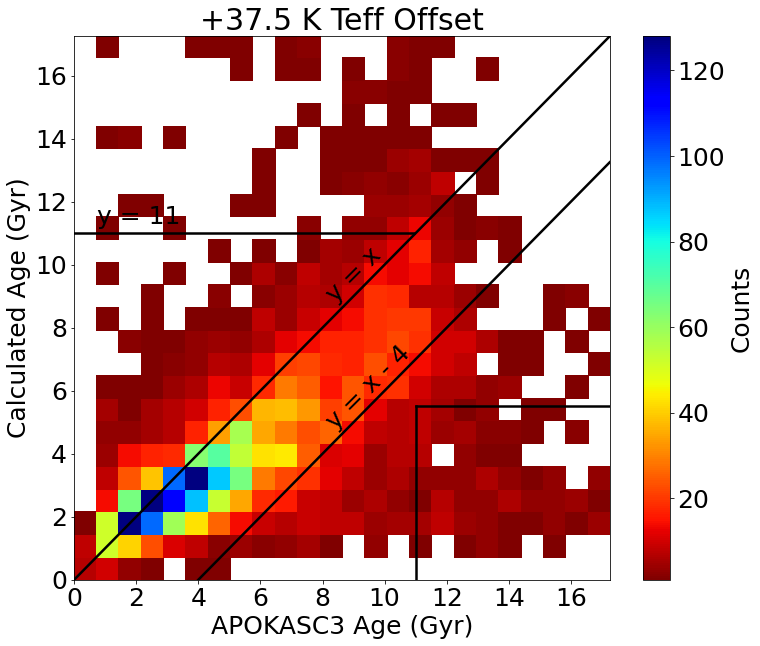

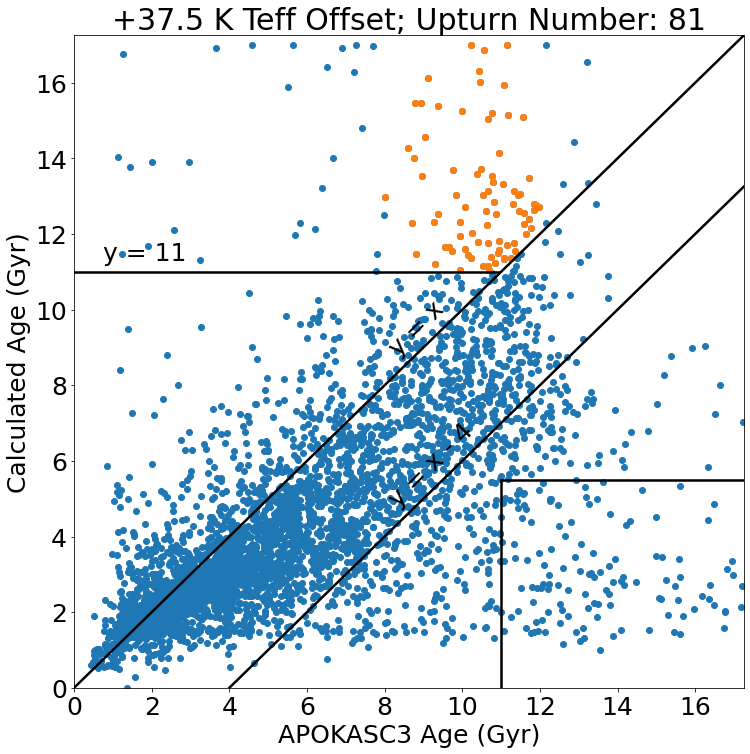

In [29]:
#############
### +37.5 ###
#############

xmax = 18
ymax = 18
nbins = 25

plt.figure(figsize=[12,10])
plt.hist2d(kasc3['IntAge'][allbad375],ages375['AGE'][allbad375],
           bins=[np.arange(0,xmax,xmax/nbins),np.arange(0,ymax,ymax/25)],cmap='jet_r',cmin=1)
plt.text(8,8.8,'y = x',rotation=45)
plt.text(8,4.8,'y = x - 4',rotation=45)
plt.text(0.75,11.3,'y = 11')

plt.plot([0,18],[0,18],lw=2.5,c='k')
plt.plot([4,17.25],[0,13.25],lw=2.5,c='k')
plt.plot([0,10.95],[11,11],lw=2.5,c='k')

plt.plot([11,11],[0,5.5],c='k',lw=2.5)
plt.plot([11,18],[5.5,5.5],c='k',lw=2.5)

plt.xlim(0,17.25)
plt.ylim(0,17.25)

plt.xticks(np.arange(0,17)[::2],np.arange(0,17)[::2].astype('str'))

plt.xlabel('APOKASC3 Age (Gyr)')
plt.ylabel('Calculated Age (Gyr)')
cbar = plt.colorbar()
cbar.ax.set_ylabel('Counts')
plt.title(r'+37.5 K Teff Offset')

### Scatter

upbox375 = np.where((ages375['AGE'][allbad375]-upturn10Gyr(kasc3['IntAge'][allbad375])>0.0)&
         (kasc3['IntAge'][allbad375]>8.0)&(kasc3['IntAge'][allbad375]<12))

plt.figure(figsize=[12,12])
plt.scatter(kasc3['IntAge'][allbad375],ages375['AGE'][allbad375])
plt.scatter(kasc3['IntAge'][allbad375][upbox375],ages375['AGE'][allbad375][upbox375])
plt.text(8,8.8,'y = x',rotation=45)
plt.text(8,4.8,'y = x - 4',rotation=45)
plt.text(0.75,11.3,'y = 11')

plt.plot([0,18],[0,18],lw=2.5,c='k')
plt.plot([4,17.25],[0,13.25],lw=2.5,c='k')
plt.plot([0,10.95],[11,11],lw=2.5,c='k')

plt.plot([11,11],[0,5.5],c='k',lw=2.5)
plt.plot([11,18],[5.5,5.5],c='k',lw=2.5)

plt.xlim(0,17.25)
plt.ylim(0,17.25)

plt.xticks(np.arange(0,17)[::2],np.arange(0,17)[::2].astype('str'))

plt.xlabel('APOKASC3 Age (Gyr)')
plt.ylabel('Calculated Age (Gyr)')
# cbar = plt.colorbar()
# cbar.ax.set_ylabel('Counts')
plt.title(r'+37.5 K Teff Offset')
plt.title(r'+37.5 K Teff Offset; Upturn Number: {}'.format(len(np.squeeze(upbox375))))
plt.savefig('../plots/age_age_scatter375.pdf',dpi=300,bbox_inches='tight')
plt.show()

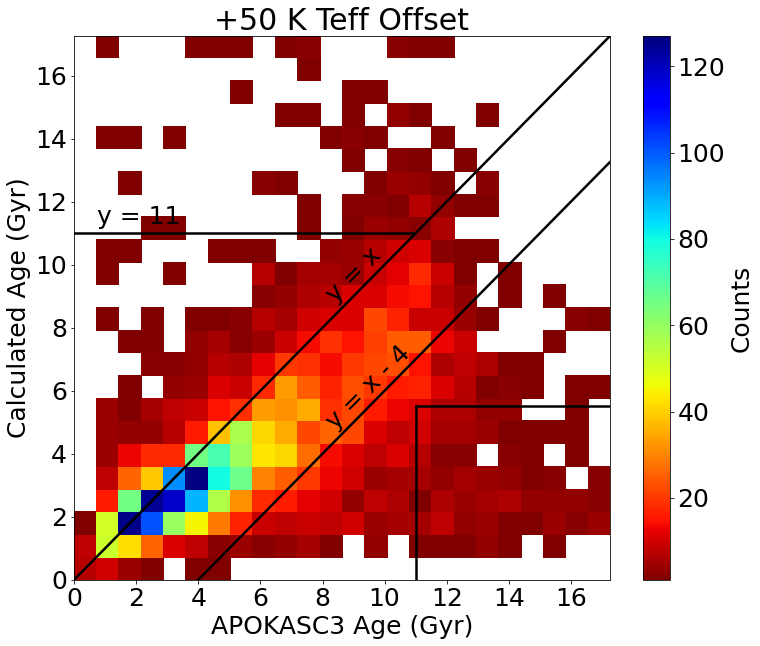

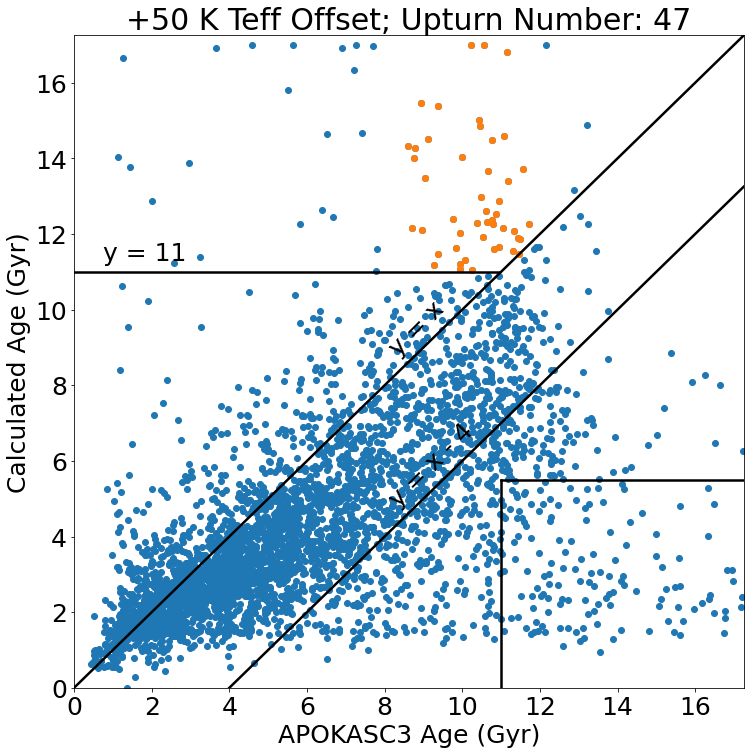

In [30]:
###########
### +50 ###
###########

xmax = 18
ymax = 18
nbins = 25

plt.figure(figsize=[12,10])
plt.hist2d(kasc3['IntAge'][allbad50],ages50['AGE'][allbad50],
           bins=[np.arange(0,xmax,xmax/nbins),np.arange(0,ymax,ymax/25)],cmap='jet_r',cmin=1)
plt.text(8,8.8,'y = x',rotation=45)
plt.text(8,4.8,'y = x - 4',rotation=45)
plt.text(0.75,11.3,'y = 11')

plt.plot([0,18],[0,18],lw=2.5,c='k')
plt.plot([4,17.25],[0,13.25],lw=2.5,c='k')
plt.plot([0,10.95],[11,11],lw=2.5,c='k')

plt.plot([11,11],[0,5.5],c='k',lw=2.5)
plt.plot([11,18],[5.5,5.5],c='k',lw=2.5)

plt.xlim(0,17.25)
plt.ylim(0,17.25)

plt.xticks(np.arange(0,17)[::2],np.arange(0,17)[::2].astype('str'))

plt.xlabel('APOKASC3 Age (Gyr)')
plt.ylabel('Calculated Age (Gyr)')
cbar = plt.colorbar()
cbar.ax.set_ylabel('Counts')
plt.title(r'+50 K Teff Offset')

### Scatter

upbox50 = np.where((ages50['AGE'][allbad50]-upturn10Gyr(kasc3['IntAge'][allbad50])>0.0)&
         (kasc3['IntAge'][allbad50]>8.0)&(kasc3['IntAge'][allbad50]<12))

plt.figure(figsize=[12,12])
plt.scatter(kasc3['IntAge'][allbad50],ages50['AGE'][allbad50])
plt.scatter(kasc3['IntAge'][allbad50][upbox50],ages50['AGE'][allbad50][upbox50])
plt.text(8,8.8,'y = x',rotation=45)
plt.text(8,4.8,'y = x - 4',rotation=45)
plt.text(0.75,11.3,'y = 11')

plt.plot([0,18],[0,18],lw=2.5,c='k')
plt.plot([4,17.25],[0,13.25],lw=2.5,c='k')
plt.plot([0,10.95],[11,11],lw=2.5,c='k')

plt.plot([11,11],[0,5.5],c='k',lw=2.5)
plt.plot([11,18],[5.5,5.5],c='k',lw=2.5)

plt.xlim(0,17.25)
plt.ylim(0,17.25)

plt.xticks(np.arange(0,17)[::2],np.arange(0,17)[::2].astype('str'))

plt.xlabel('APOKASC3 Age (Gyr)')
plt.ylabel('Calculated Age (Gyr)')
# cbar = plt.colorbar()
# cbar.ax.set_ylabel('Counts')
plt.title(r'+50 K Teff Offset; Upturn Number: {}'.format(len(np.squeeze(upbox50))))
plt.savefig('../plots/age_age_scatter50.pdf',dpi=300,bbox_inches='tight')
plt.show()

Text(0.5, 1.0, '+50 K Teff Offset; Upturn Number: 47')

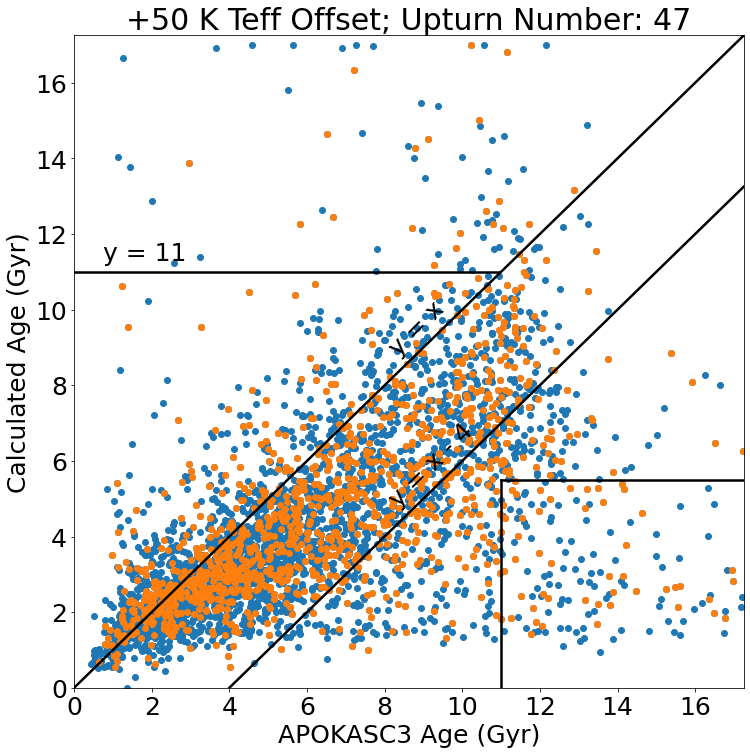

In [31]:
plt.figure(figsize=[12,12])
plt.scatter(kasc3['IntAge'][allbad50],ages50['AGE'][allbad50])
plt.scatter(kasc3['IntAge'][allbad50][hibad50],ages50['AGE'][allbad50][hibad50])
plt.text(8,8.8,'y = x',rotation=45)
plt.text(8,4.8,'y = x - 4',rotation=45)
plt.text(0.75,11.3,'y = 11')

plt.plot([0,18],[0,18],lw=2.5,c='k')
plt.plot([4,17.25],[0,13.25],lw=2.5,c='k')
plt.plot([0,10.95],[11,11],lw=2.5,c='k')

plt.plot([11,11],[0,5.5],c='k',lw=2.5)
plt.plot([11,18],[5.5,5.5],c='k',lw=2.5)

plt.xlim(0,17.25)
plt.ylim(0,17.25)

plt.xticks(np.arange(0,17)[::2],np.arange(0,17)[::2].astype('str'))

plt.xlabel('APOKASC3 Age (Gyr)')
plt.ylabel('Calculated Age (Gyr)')
# cbar = plt.colorbar()
# cbar.ax.set_ylabel('Counts')
plt.title(r'+50 K Teff Offset; Upturn Number: {}'.format(len(np.squeeze(upbox50))))

# Resid Plots

In [32]:
from scipy.stats import binned_statistic

In [33]:
ages_arr = np.array([ages0['AGE'],ages125['AGE'],ages25['AGE'],ages375['AGE'],ages50['AGE']])
lab_arr = ['0 K','12.5 K','25 K','37.5 K','50 K']
fil_arr = ['0K','125K','25K','375K','50K']

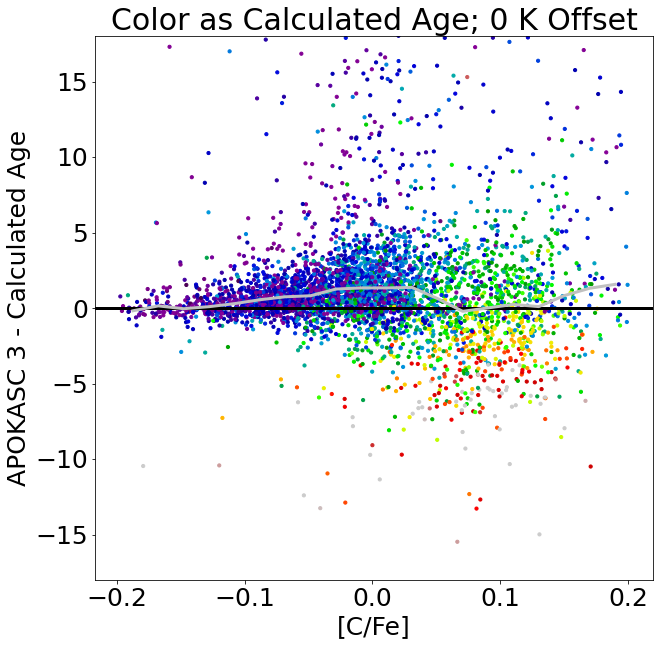

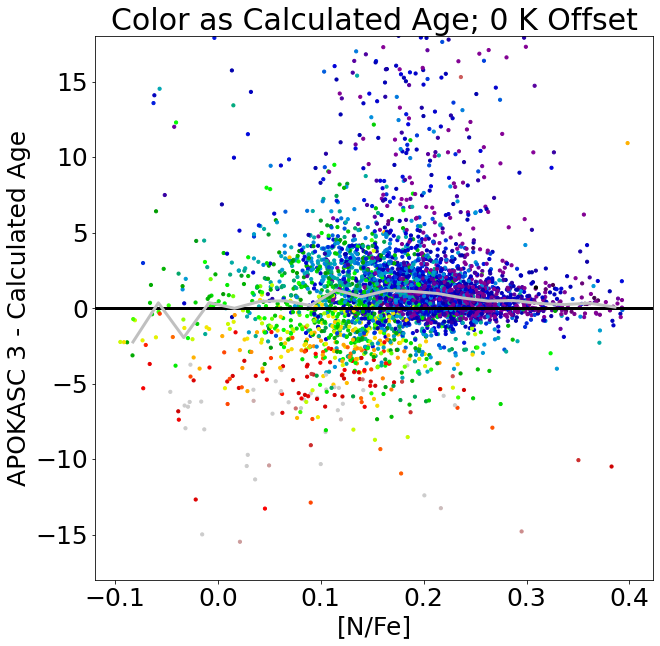

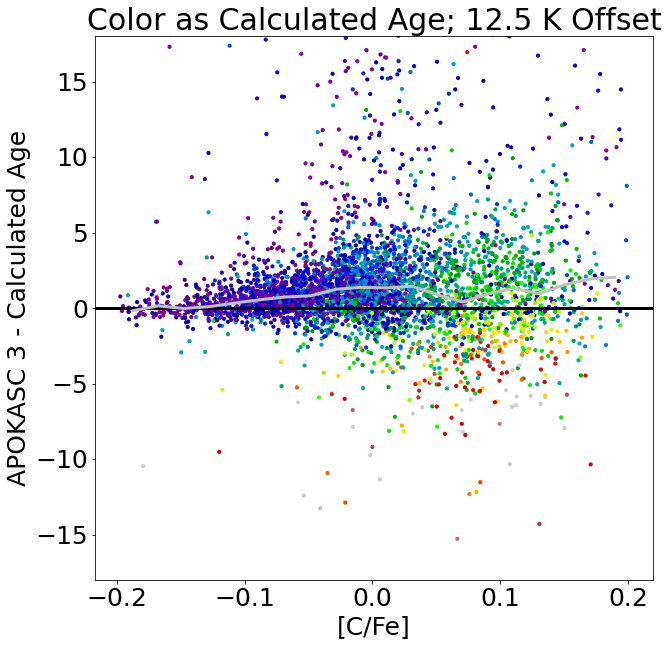

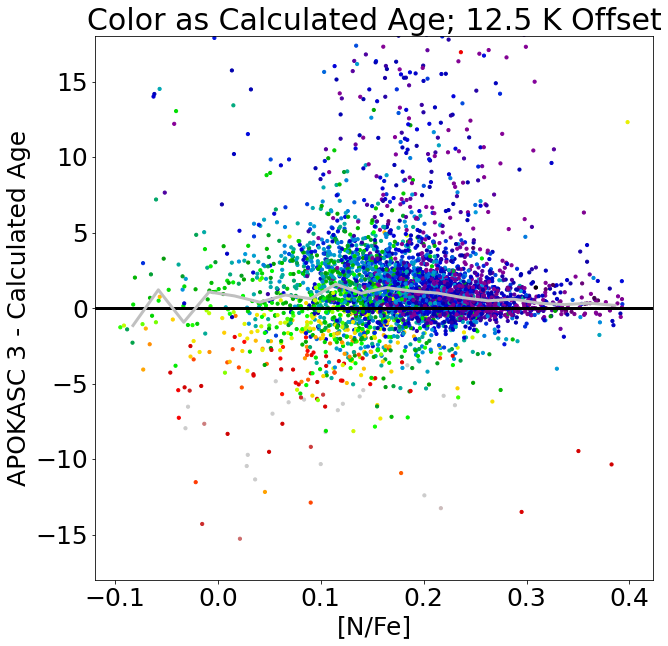

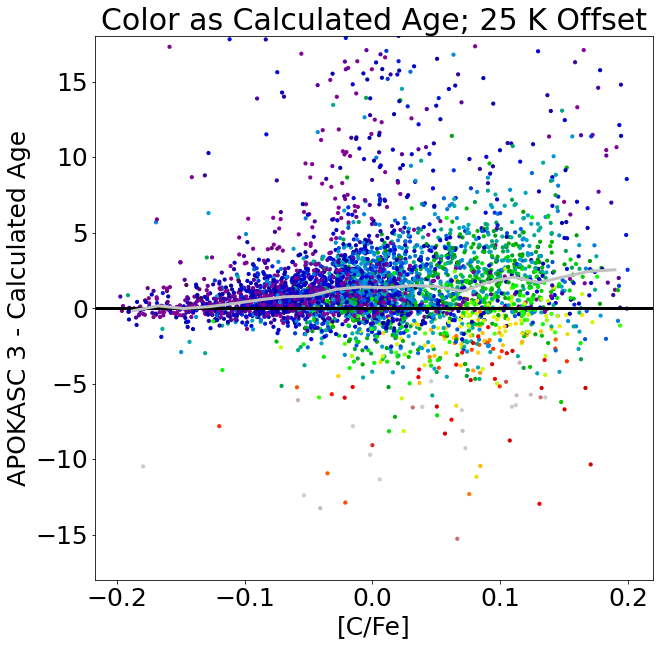

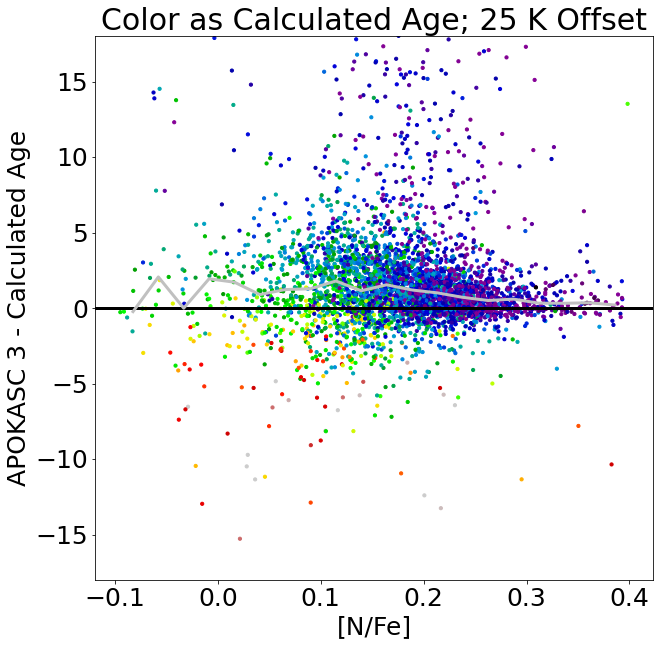

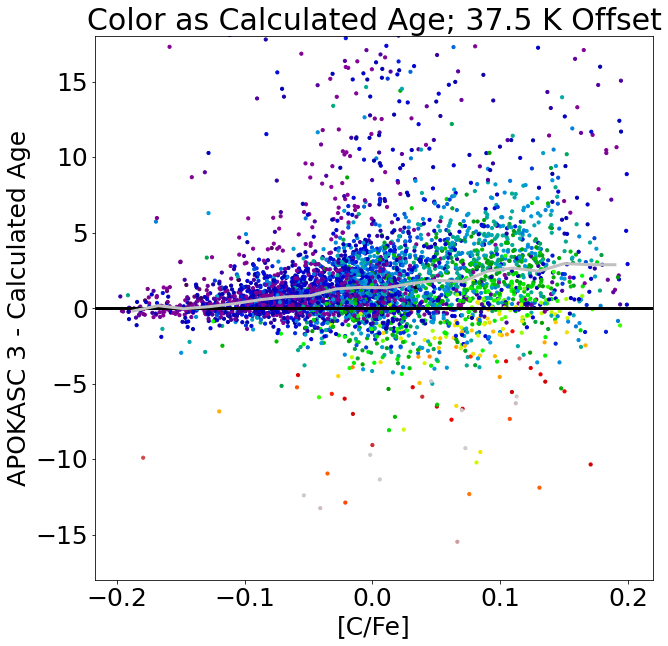

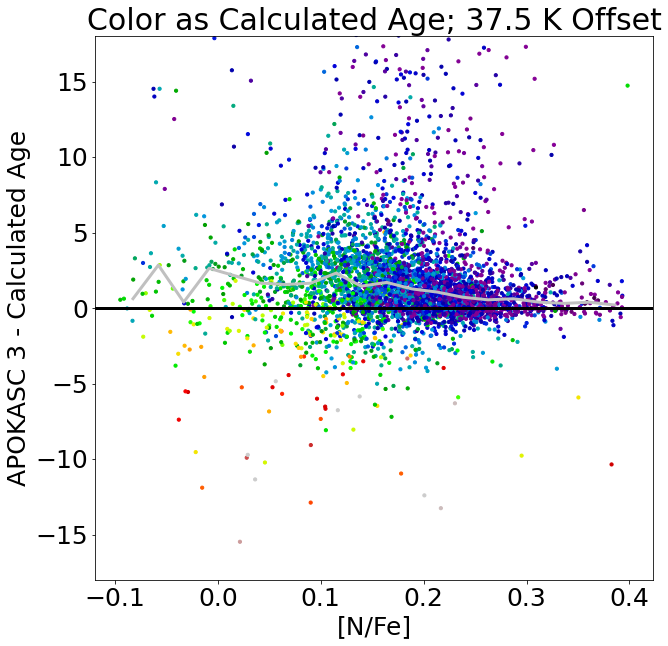

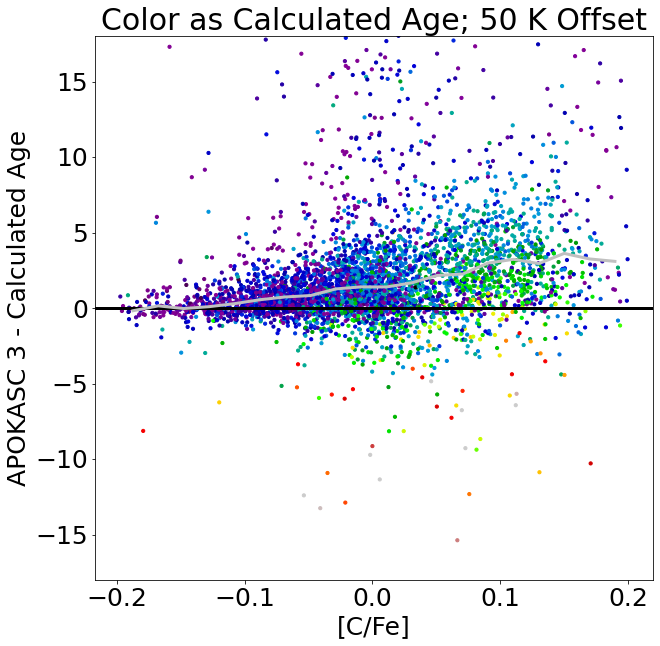

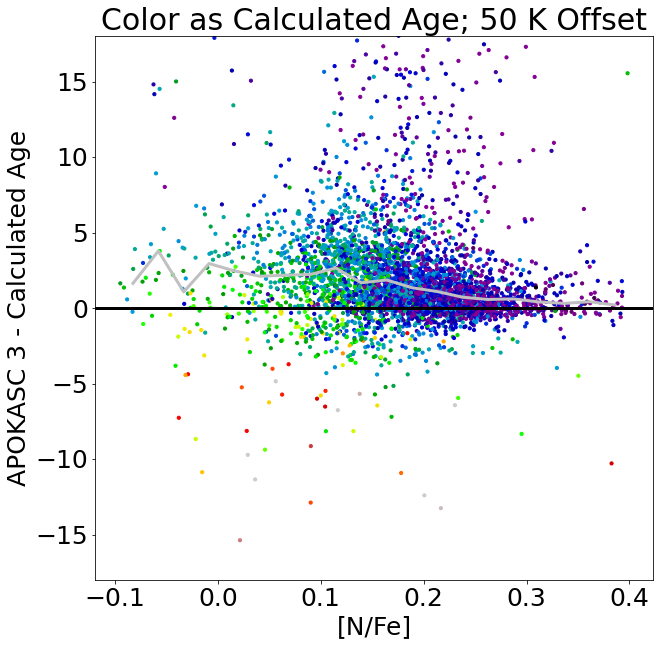

In [34]:
for i in range(len(ages_arr)):
    cln = np.where((ages_arr[i]<20.)&(kasc3dr17['C_FE']>-0.2)&(kasc3dr17['C_FE']<0.2))
    nbins=20
    ### resid C_FE
    cfe_medians,cfe_edges,cfenumber = binned_statistic(kasc3dr17['C_FE'][cln],
                                                       (kasc3['IntAge']-ages_arr[i])[cln],
                                                       statistic='median',bins=nbins)
#     cfe_mads, _, _ = binned_statistic(kasc3dr17['C_FE'][cln],(kasc3['IntAge']-ages_arr[i])[cln],
#                                       statistic=lambda y: np.nanmedian(np.abs(y-np.nanmedian(y))),bins=nbins)
    
    plt.figure(figsize=[10,10])

    plt.scatter(kasc3dr17['C_FE'][cln],(kasc3['IntAge']-ages_arr[i])[cln],
                c=ages_arr[i][cln],cmap='nipy_spectral',s=10)
    
    plt.axhline(0.,c='k',lw=3)
#     plt.hlines(cfe_medians,cfe_edges[:-1],cfe_edges[1:],colors='r',lw=3)
    plt.plot((cfe_edges[:-1]+cfe_edges[1:])/2,cfe_medians,c='silver',lw=3)#,yerr=cfe_mads,c='silver',lw=3)

#     plt.colorbar()

    plt.ylim(-18,18)
#     plt.xlim(-0.3,0.3)

    plt.title(r'Color as Calculated Age; {} Offset'.format(lab_arr[i]))
    plt.xlabel(r'[C/Fe]')
    plt.ylabel(r'APOKASC 3 - Calculated Age')
    plt.savefig('../plots/CFE_resid_calculated{}.pdf'.format(fil_arr[i]),dpi=300,bbox_inches='tight')
    plt.show()

    ### resid N_FE
    cln = np.where((ages_arr[i]<20.)&(kasc3dr17['N_FE']>-0.1)&(kasc3dr17['N_FE']<0.4))
    nfe_medians,nfe_edges,_ = binned_statistic(kasc3dr17['N_FE'][cln],
                                                       (kasc3['IntAge']-ages_arr[i])[cln],
                                               statistic='median',bins=nbins)
#     nfe_mads, _, _ = binned_statistic(kasc3dr17['N_FE'][cln],(kasc3['IntAge']-ages_arr[i])[cln],
#                                       statistic=lambda y: np.nanmedian(np.abs(y-np.nanmedian(y))),bins=nbins)
    
    plt.figure(figsize=[10,10])

    plt.scatter(kasc3dr17['N_FE'][cln],(kasc3['IntAge']-ages_arr[i])[cln],
                c=ages_arr[i][cln],cmap='nipy_spectral',s=10)
    
    plt.axhline(0.,c='k',lw=3)
#     plt.hlines(nfe_medians,nfe_edges[:-1],nfe_edges[1:],colors='r',lw=3)
    plt.plot((nfe_edges[:-1]+nfe_edges[1:])/2,nfe_medians,c='silver',lw=3)#,yerr=nfe_mads,c='silver',lw=3)

#     plt.colorbar()

    plt.ylim(-18,18)
#     plt.xlim(-0.1,0.4)

    plt.title(r'Color as Calculated Age; {} Offset'.format(lab_arr[i]))
    plt.xlabel(r'[N/Fe]')
    plt.ylabel(r'APOKASC 3 - Calculated Age')
    plt.savefig('../plots/NFE_resid_calculated{}.pdf'.format(fil_arr[i]),dpi=300,bbox_inches='tight')
    plt.show()

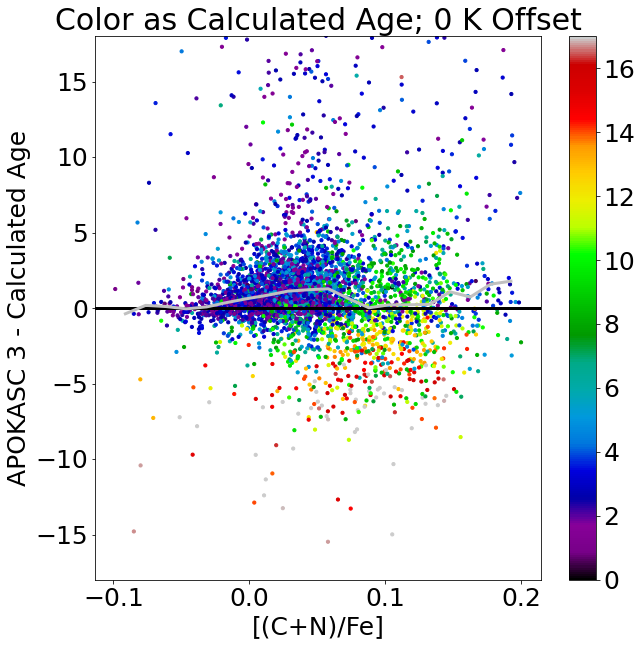

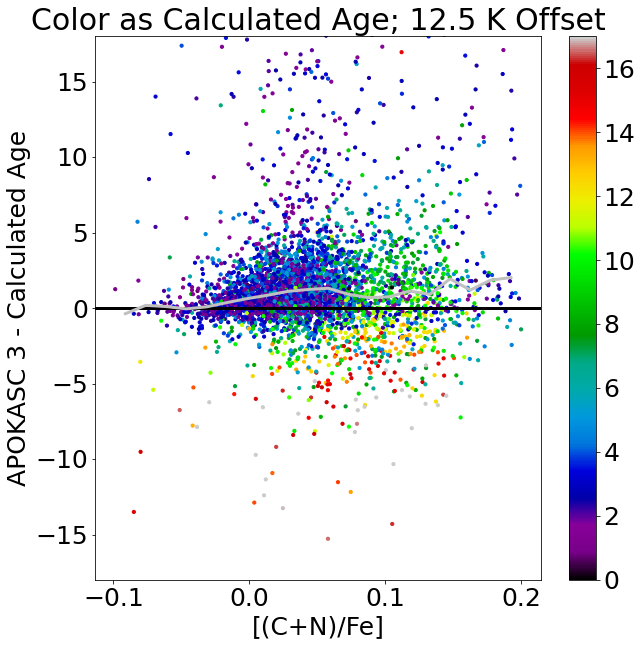

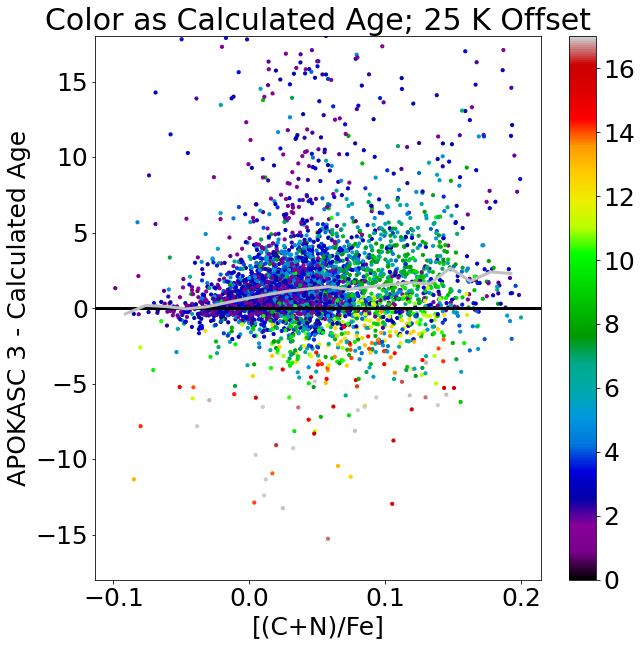

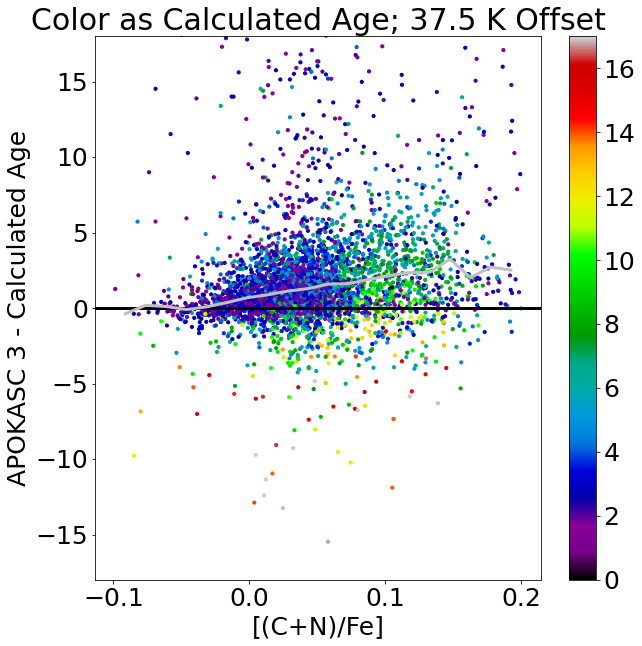

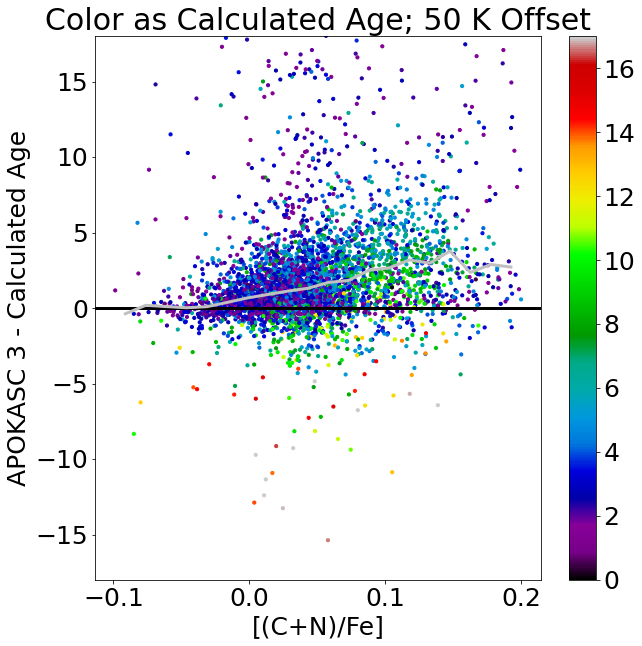

In [35]:
### [(C+N)/Fe]

cfrac = (10**(8.43))/(10**(8.43)+10**(7.83))
nfrac = (10**(7.83))/(10**(8.43)+10**(7.83))

cnfe = np.log10(cfrac*10**(kasc3dr17['C_FE'])+nfrac*10**(kasc3dr17['N_FE']))

for i in range(len(ages_arr)):
    cln = np.where((ages_arr[i]<20.)&(cnfe>-0.1)&(cnfe<0.2))
    nbins=20
    
    cnfe_medians,cnfe_edges,_ = binned_statistic(cnfe[cln],(kasc3['IntAge']-ages_arr[i])[cln],
                                                 statistic='median',bins=nbins)
#     cnfe_mads, _, _ = binned_statistic(cnfe[cln],(kasc3['IntAge']-ages_arr[i])[cln],
#                                       statistic=lambda y: np.nanmedian(np.abs(y-np.nanmedian(y))),bins=nbins)
    
    plt.figure(figsize=[10,10])

    plt.scatter(cnfe[cln],(kasc3['IntAge']-ages_arr[i])[cln],s=10,
                c=ages_arr[i][cln],cmap='nipy_spectral')
    
    plt.axhline(0.,c='k',lw=3)
    plt.plot((cnfe_edges[:-1]+cnfe_edges[1:])/2,cnfe_medians,c='silver',lw=3)#,yerr=cnfe_mads,c='silver',lw=3)

    plt.colorbar()

    plt.ylim(-18,18)
#     plt.xlim(-0.3,0.3)

    plt.title(r'Color as Calculated Age; {} Offset'.format(lab_arr[i]))
    plt.xlabel(r'[(C+N)/Fe]')
    plt.ylabel(r'APOKASC 3 - Calculated Age')
    plt.savefig('../plots/CNFE_resid_calculated{}.pdf'.format(fil_arr[i]),dpi=300,bbox_inches='tight')
    plt.show()

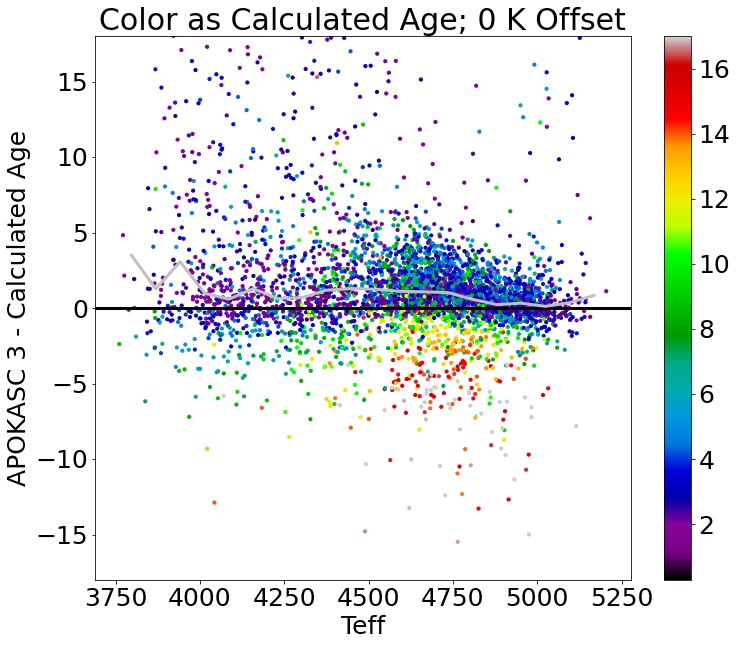

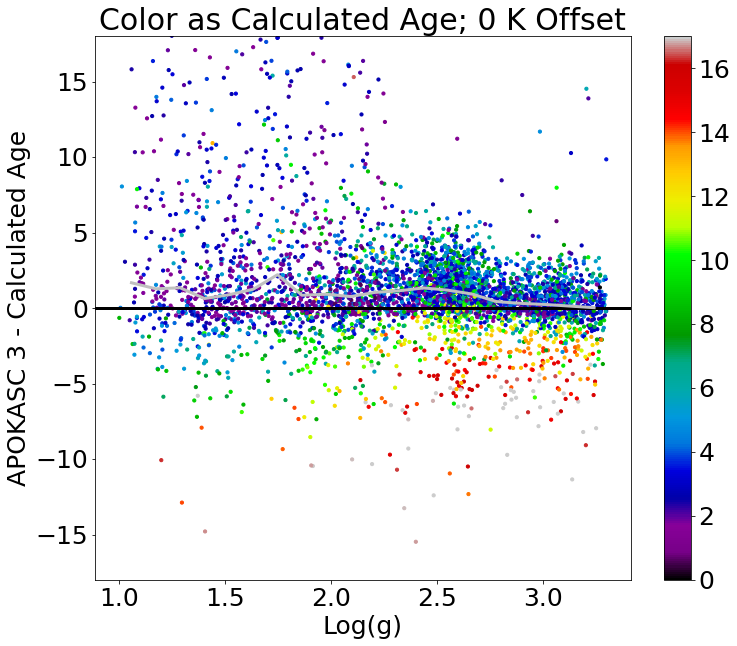

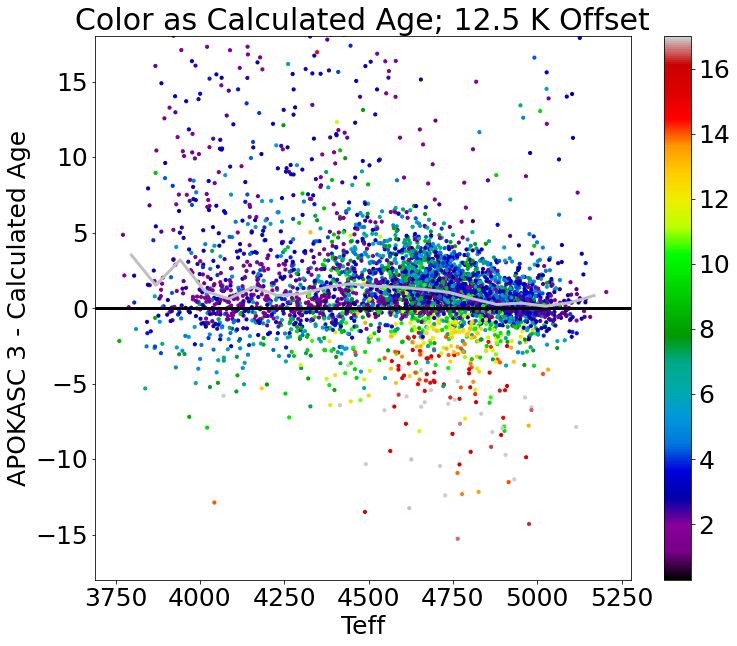

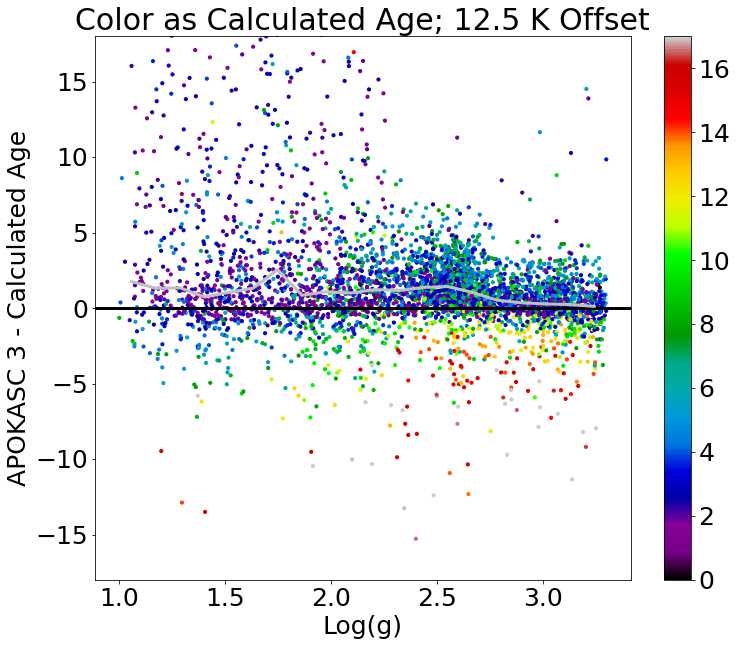

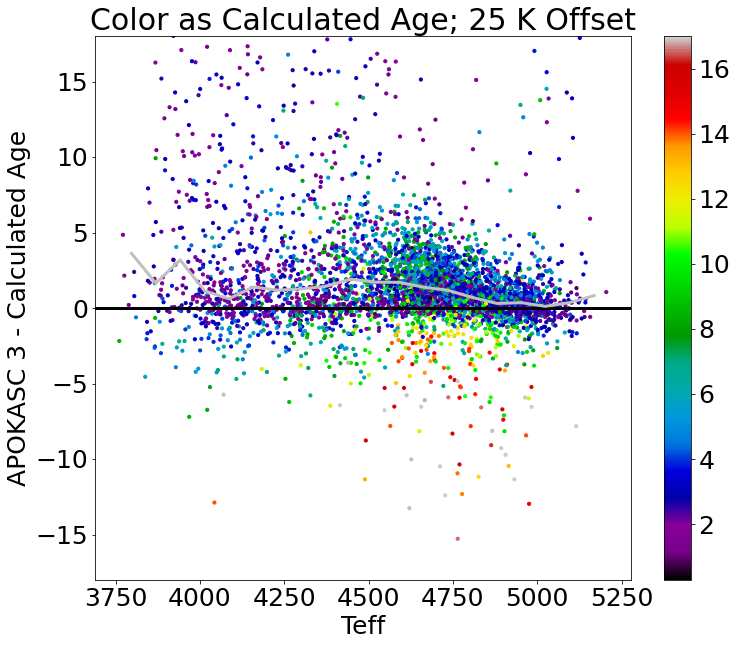

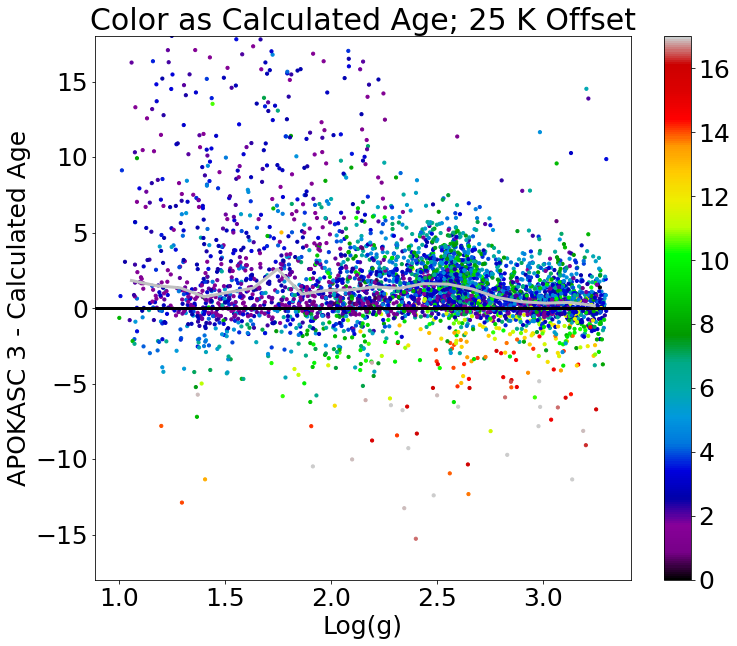

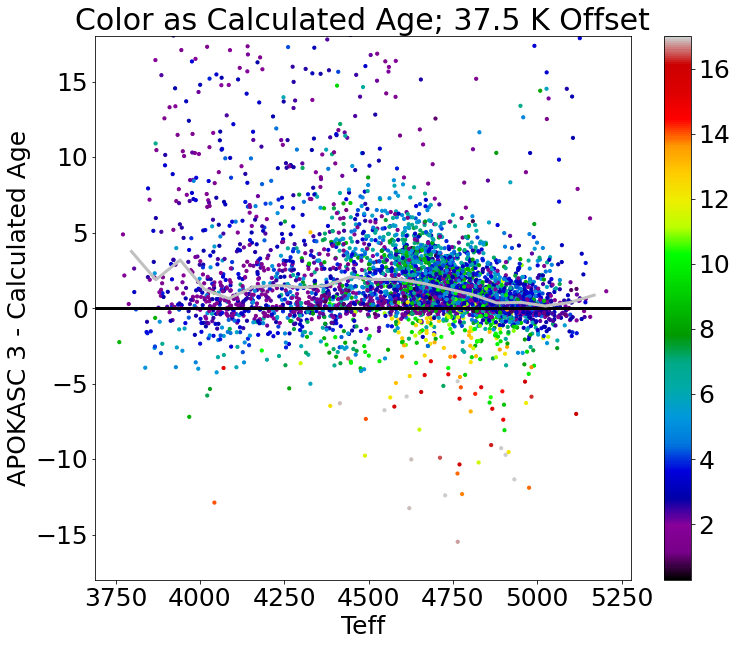

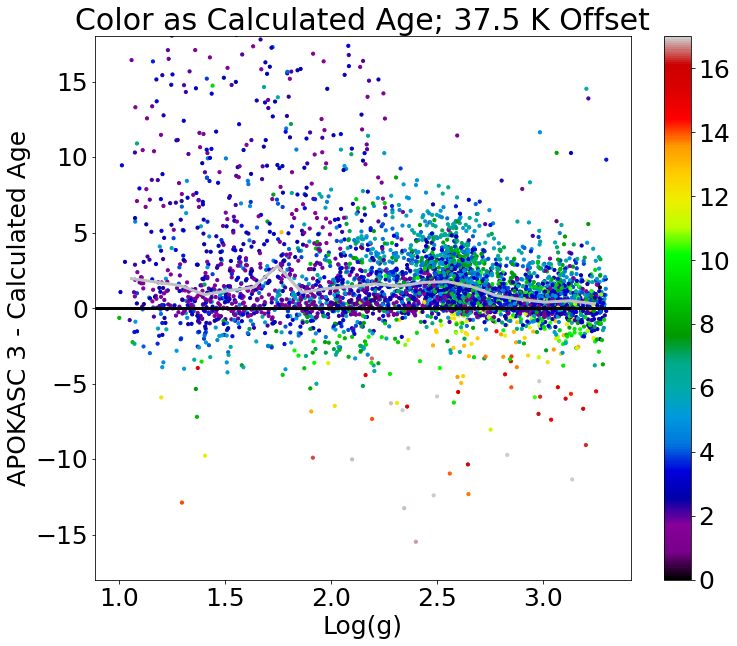

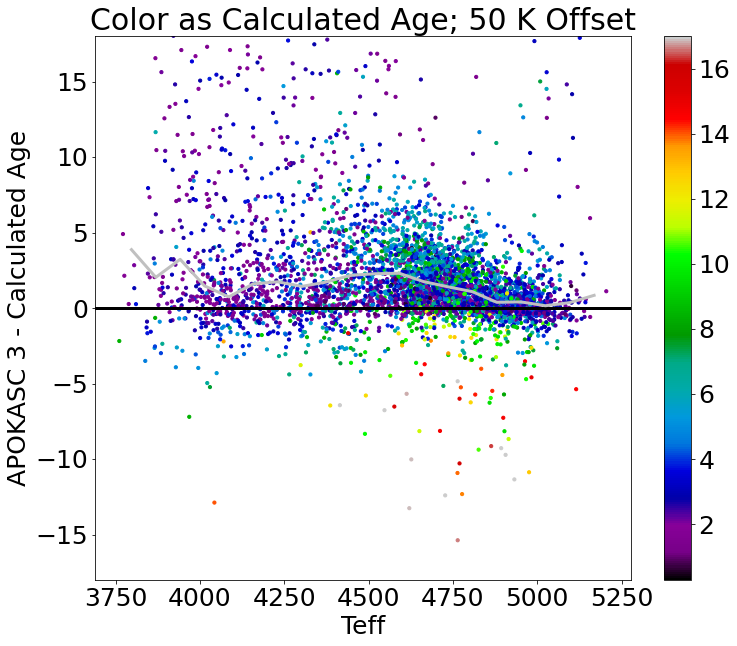

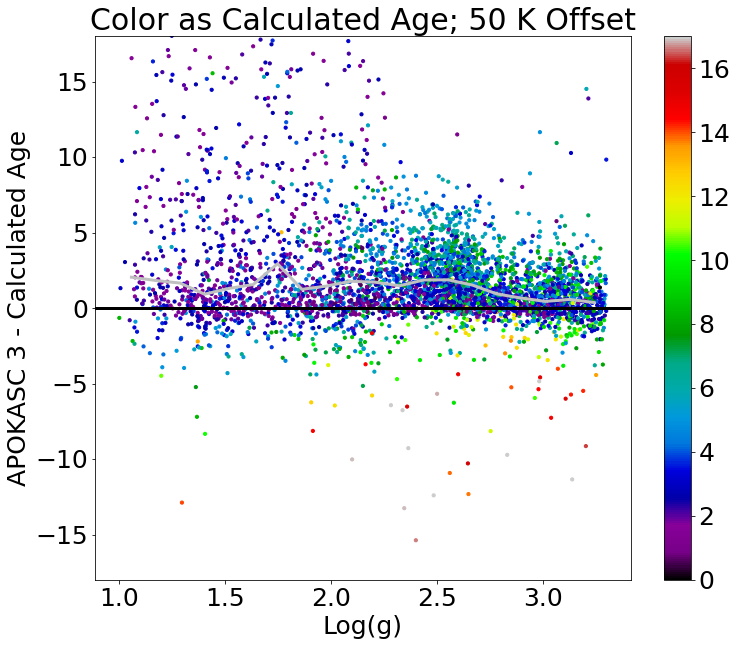

In [36]:
for i in range(len(ages_arr)):
    cln = np.where((ages_arr[i]<20.)&(kasc3dr17['TEFF']>3750)&(kasc3dr17['TEFF']<5250))
    ### resid TEFF
    nbins = 20
    teff_medians,teff_edges,_ = binned_statistic(kasc3dr17['TEFF'][cln],(kasc3['IntAge']-ages_arr[i])[cln],
                                               statistic='median',bins=nbins)
#     teff_mads, _, _ = binned_statistic(kasc3dr17['TEFF'][cln],(kasc3['IntAge']-ages_arr[i])[cln],
#                                       statistic=lambda y: np.nanmedian(np.abs(y-np.nanmedian(y))),bins=nbins)
    
    plt.figure(figsize=[12,10])

    plt.scatter(kasc3dr17['TEFF'][cln],(kasc3['IntAge']-ages_arr[i])[cln],
                c=ages_arr[i][cln],cmap='nipy_spectral',s=10)

    plt.colorbar()
    
    plt.axhline(0.,c='k',lw=3)
#     plt.hlines(teff_medians,teff_edges[:-1],teff_edges[1:],colors='r',lw=3)
    plt.plot((teff_edges[:-1]+teff_edges[1:])/2,teff_medians,c='silver',lw=3)#,yerr=teff_mads,c='silver',lw=3)

    plt.ylim(-18,18)
#     plt.xlim(left=-0.6)

    plt.title(r'Color as Calculated Age; {} Offset'.format(lab_arr[i]))
    plt.xlabel(r'Teff')
    plt.ylabel(r'APOKASC 3 - Calculated Age')
    plt.savefig('../plots/resid_TEFF_calculated{}.pdf'.format(fil_arr[i]),dpi=300,bbox_inches='tight')
    plt.show()

    ### resid LOGG
    cln = np.where((ages_arr[i]<20.)&(kasc3dr17['LOGG']>1)&(kasc3dr17['LOGG']<3.3))
    logg_medians,logg_edges,_ = binned_statistic(kasc3dr17['LOGG'][cln],(kasc3['IntAge']-ages_arr[i])[cln],
                                               statistic='median',bins=nbins)
#     logg_mads, _, _ = binned_statistic(kasc3dr17['LOGG'][cln],(kasc3['IntAge']-ages_arr[i])[cln],
#                                       statistic=lambda y: np.nanmedian(np.abs(y-np.nanmedian(y))),bins=nbins)
    
    plt.figure(figsize=[12,10])

    plt.scatter(kasc3dr17['LOGG'][cln],(kasc3['IntAge']-ages_arr[i])[cln],
                c=ages_arr[i][cln],cmap='nipy_spectral',s=10)

    plt.colorbar()
    
    plt.axhline(0.,c='k',lw=3)
#     plt.hlines(logg_medians,logg_edges[:-1],logg_edges[1:],colors='r',lw=3)
    plt.plot((logg_edges[:-1]+logg_edges[1:])/2,logg_medians,c='silver',lw=3)#,yerr=logg_mads,c='silver',lw=3)

    plt.ylim(-18,18)
#     plt.xlim(left=-0.6)

    plt.title(r'Color as Calculated Age; {} Offset'.format(lab_arr[i]))
    plt.xlabel(r'Log(g)')
    plt.ylabel(r'APOKASC 3 - Calculated Age')
    plt.savefig('../plots/resid_LOGG_calculated{}.pdf'.format(fil_arr[i]),dpi=300,bbox_inches='tight')
    plt.show()

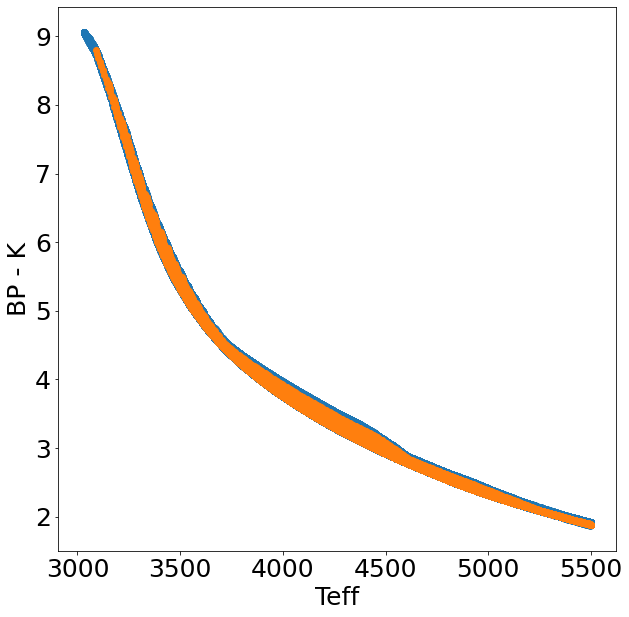

In [52]:
teffcut = np.where(10**massive['logTe']<5500)
teffcut12gyr = np.where((10**massive['logTe']<5500)&
                        (massive['logAge']==closest(massive['logAge'],np.log10(12*10**9))))

plt.figure(figsize=[10,10])
plt.scatter(10**massive['logTe'][teffcut],(massive['G_BPmag']-massive['Ksmag'])[teffcut])
plt.scatter(10**massive['logTe'][teffcut12gyr],(massive['G_BPmag']-massive['Ksmag'])[teffcut12gyr])
plt.xlabel(r'Teff')
plt.ylabel(r'BP - K')
plt.show()

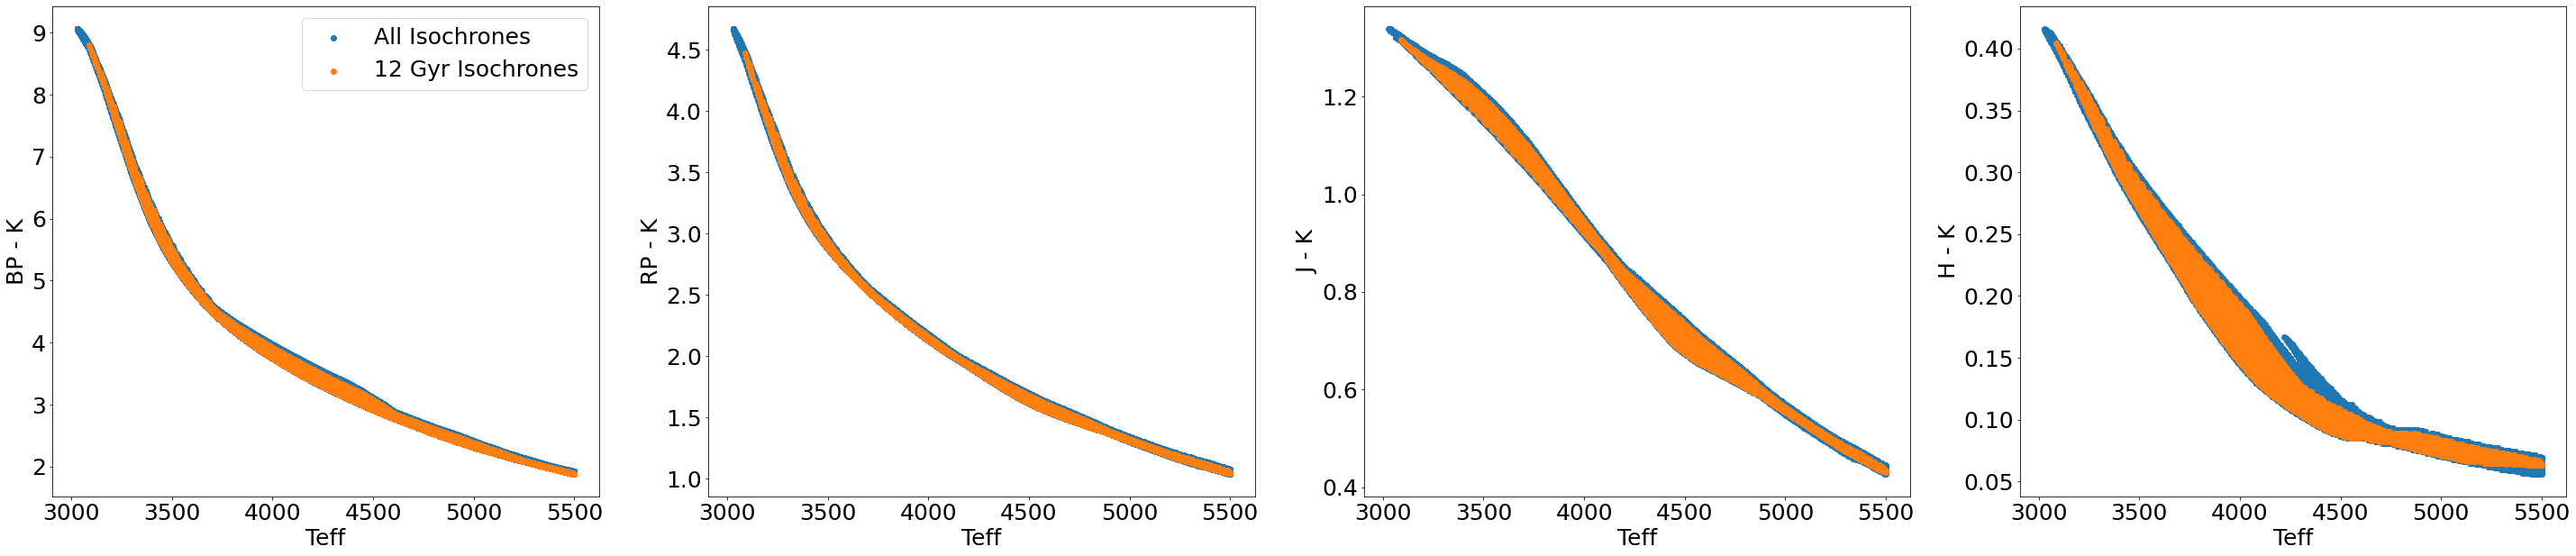

In [74]:
nonfid = ['G_BPmag','G_RPmag','Jmag','Hmag']
collabs = ['BP - K', 'RP - K', 'J - K', 'H - K']

teffcut = np.where((10**massive['logTe']<5500)&(10**massive['logAge']/10**9>=0.25))
teffcut12gyr = np.where((10**massive['logTe']<5500)&
                        (massive['logAge']==closest(massive['logAge'],np.log10(12*10**9))))

fig, ax = plt.subplots(1,4,figsize=[50,10])
# plt.suptitle(r'Color-Teff')
for i in range(len(ax)):
    ax[i].scatter(10**massive['logTe'][teffcut],(massive[nonfid[i]]-massive['Ksmag'])[teffcut],
                  label='All Isochrones')
    ax[i].scatter(10**massive['logTe'][teffcut12gyr],(massive[nonfid[i]]-massive['Ksmag'])[teffcut12gyr],
                  label='12 Gyr Isochrones')
    ax[i].set_xlabel(r'Teff')
    ax[i].set_ylabel(collabs[i])
    
ax[0].legend()
    
plt.savefig('../plots/teffcolorrange.pdf',dpi=300,bbox_inches='tight')
plt.show()

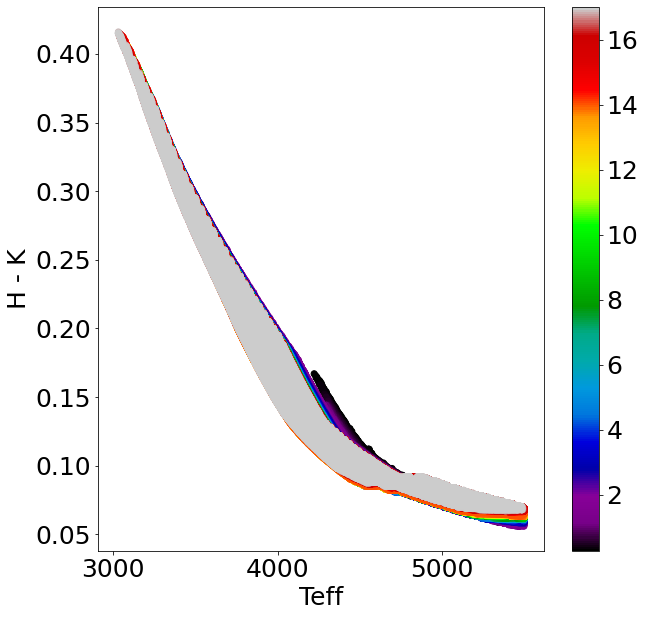

In [73]:
teffcut2 = np.where((10**massive['logTe']<5500)&(10**massive['logAge']/10**9>=0.25))
plt.figure(figsize=[10,10])
plt.scatter(10**massive['logTe'][teffcut2],(massive['Hmag']-massive['Ksmag'])[teffcut2],
            c=10**massive['logAge'][teffcut2]/10**9,cmap='nipy_spectral')
plt.colorbar()
plt.xlabel(r'Teff')
plt.ylabel(r'H - K')
plt.show()

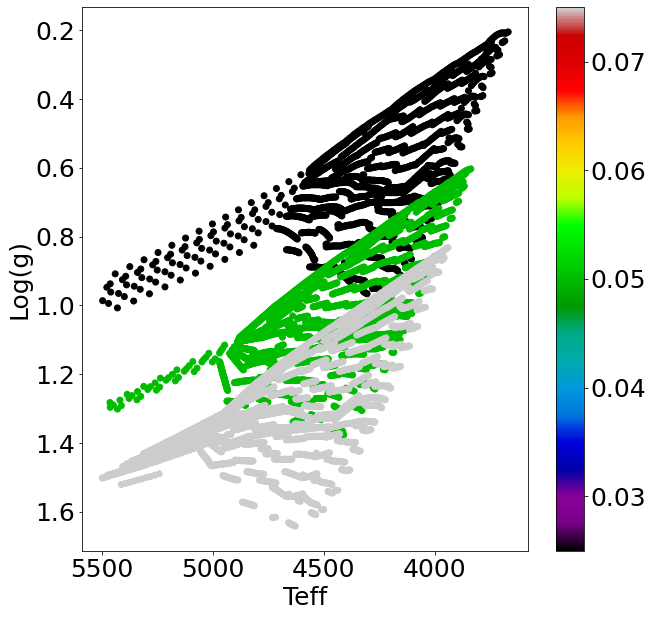

In [65]:
youngcut = np.where((10**massive['logAge']/10**9<0.1)&(10**massive['logTe']<5500))
plt.figure(figsize=[10,10])
plt.scatter(10**massive['logTe'][youngcut],massive['logg'][youngcut],
            c=10**massive['logAge'][youngcut]/10**9,cmap='nipy_spectral')
plt.colorbar()
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.xlabel(r'Teff')
plt.ylabel(r'Log(g)')
plt.show()

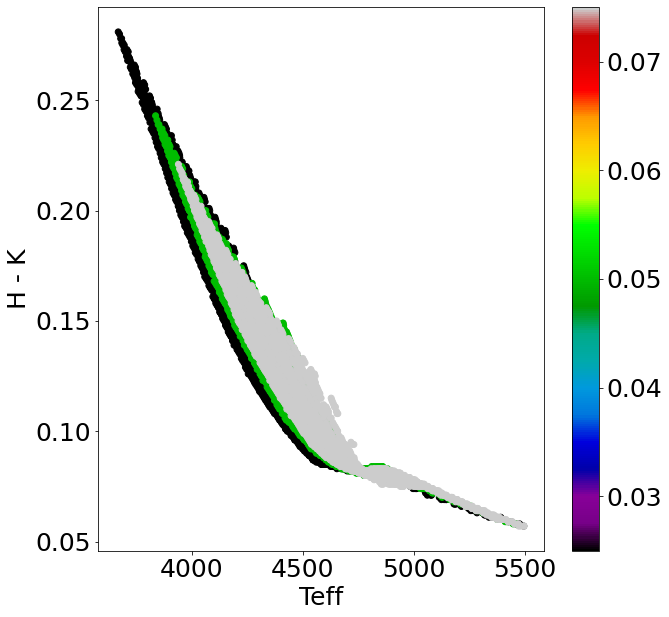

In [66]:
plt.figure(figsize=[10,10])
plt.scatter(10**massive['logTe'][youngcut],(massive['Hmag']-massive['Ksmag'])[youngcut],
            c=10**massive['logAge'][youngcut]/10**9,cmap='nipy_spectral')
plt.colorbar()
plt.xlabel(r'Teff')
plt.ylabel(r'H - K')
plt.show()

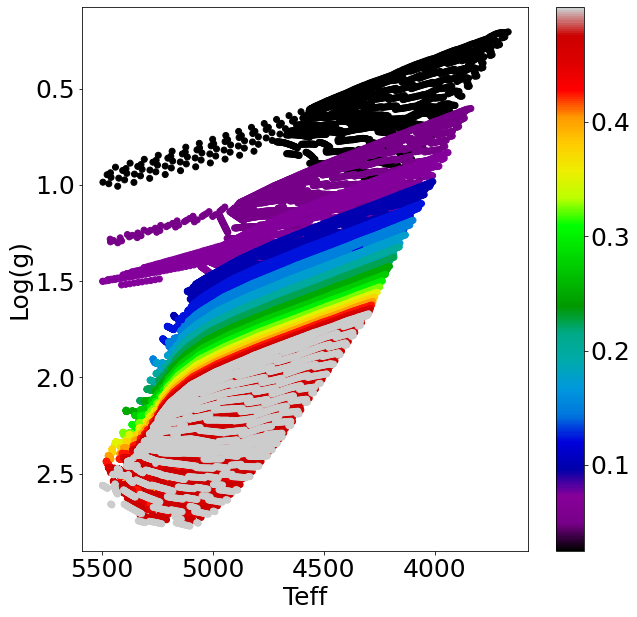

In [70]:
youngcut2 = np.where((10**massive['logAge']/10**9<0.5)&(10**massive['logTe']<5500))
plt.figure(figsize=[10,10])
plt.scatter(10**massive['logTe'][youngcut2],massive['logg'][youngcut2],
            c=10**massive['logAge'][youngcut2]/10**9,cmap='nipy_spectral')
plt.colorbar()
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.xlabel(r'Teff')
plt.ylabel(r'Log(g)')
plt.show()

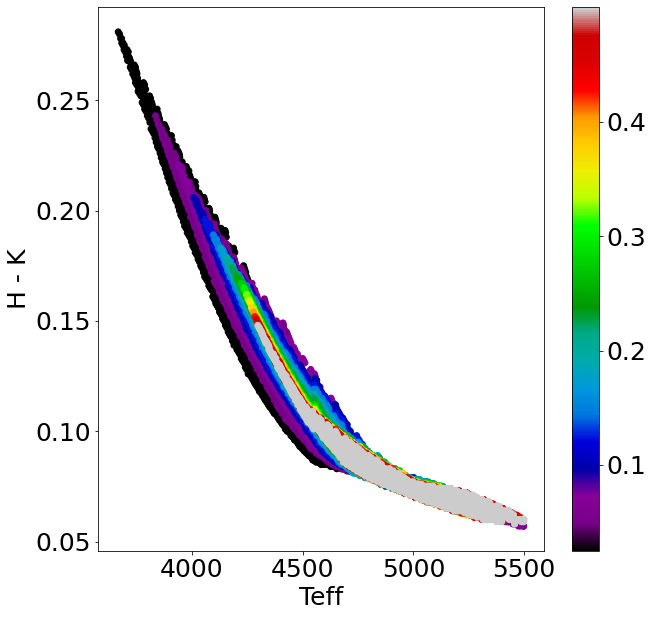

In [71]:
plt.figure(figsize=[10,10])
plt.scatter(10**massive['logTe'][youngcut2],(massive['Hmag']-massive['Ksmag'])[youngcut2],
            c=10**massive['logAge'][youngcut2]/10**9,cmap='nipy_spectral')
plt.colorbar()
plt.xlabel(r'Teff')
plt.ylabel(r'H - K')
plt.show()

In [39]:
max(10**massive['logTe'])

12017.108988505177

In [40]:
max(kasc3dr17['TEFF'])

5275.411

In [45]:
test = fits.getdata('/Users/joshuapovick/Desktop/Research/fits/lmc_rgbmembers.dr17_qacuts.fits.gz')

In [49]:
min(test['TEFF'])

3177.1

In [47]:
max(kasc3dr17['TEFF'])

5275.411

In [50]:
min(10**massive['logTe'][teffcut12gyr])

3088.8726265127525